# Settings

In this notebook we work with the problem of multi-class classification, that is, the correct assignment of an object to one of the classes. Our goal is to achieve high accuracy of assignment to the correct category. We will use the widely used transfer learning method.


Transfer learning is a machine learning technique that uses a pre-trained model. In this approach, a model trained on one data is used or retrained for use with another set of data. By using transfer learning, you can achieve significantly higher classification accuracy, especially when the available data set is limited.

Before running the code, we need to make sure that we are using the GPU. We plan to work with a convolutional neural network, and using a GPU allows us to reduce training time by several times.

In [1]:
# display information about available GPU devices
!nvidia-smi

Sat Jan 20 01:18:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import libraries

In [2]:
# Visualization purpose
!pip install tensorboardX
!pip install tensorboard
!pip install tensorboard-plugin-customizable-plots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 50.9 MB/s eta 0:00:00


In [3]:
!pip install split-folders
!pip install optuna
!pip install --upgrade nvidia-ml-py3
!pip install codecarbon

  Preparing metadata (setup.py) ... - \ done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19189 sha256=ba1ffa9200e010819e9681a17e5444b0f483df4054e5e51d68d5f3454c0ac3e1
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 7.6 MB/s eta 0:00:00


In [4]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt 
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from codecarbon import EmissionsTracker

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Description of the data set

The set used has about 22,000 images of various types of waste, divided into 10 different categories - metal, glass, biological waste, etc.


# Data Preprcessing

In [6]:
prepare_data_emission_tracker = EmissionsTracker()
prepare_data_emission_tracker.start()

[codecarbon INFO @ 01:20:15] [setup] RAM Tracking...
[codecarbon INFO @ 01:20:15] [setup] GPU Tracking...
[codecarbon INFO @ 01:20:15] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:20:15] [setup] CPU Tracking...
[codecarbon WARNING @ 01:20:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 01:20:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 01:20:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 01:20:16] >>> Tracker's metadata:
[codecarbon INFO @ 01:20:16]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 01:20:16]   Python version: 3.10.10
[codecarbon INFO @ 01:20:16]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 01:20:16]   Available RAM : 31.358 GB
[codecarbon INFO @ 01:20:16]   CPU count: 4
[codecarbon INFO @ 01:20:16]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 01:20:16]   GPU

In [7]:
data_dir = '/kaggle/input/garbage-classification-v2/'

Cleaning the working directory if there are any files in it

In [8]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
# os.rmdir(folder_path)

Copying the dataset to the working directory to allow data cleaning

In [9]:
shutil.copytree(data_dir, '/kaggle/working/dataset')

[codecarbon INFO @ 01:20:34] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:20:34] Energy consumed for all GPUs : 0.000083 kWh. Total GPU Power : 19.83167010586908 W
[codecarbon INFO @ 01:20:34] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:20:34] 0.000309 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:20:49] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:20:49] Energy consumed for all GPUs : 0.000165 kWh. Total GPU Power : 19.763183253604133 W
[codecarbon INFO @ 01:20:49] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:20:49] 0.000617 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:21:04] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:21:04] Energy consumed for all GPUs : 0.000247 kWh. Total GPU Power : 19.7165724789

'/kaggle/working/dataset'

In [10]:
data_dir  = '/kaggle/working/dataset'

In [11]:
experiment_name = "Transfer Learning"

The Tensorflow library that we are going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [12]:
count=0
image_extensions = [".png", ".jpg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/cardboard/cardboard_313.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_313.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/cardboard/cardboard_2088.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_2088.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/cardboard/cardboard_1110.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_1110.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/cardboard/cardboard_653.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_653.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/cardboard/cardboard_1141.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_1141.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/cardboard/cardboard_2339.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_2339.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/cardboard/cardboard_

To train the model, you will need to divide the data into several samples, so we will create folders for them

In [13]:
os.mkdir('data')

In [14]:
os.chdir('data')

In [15]:
os.getcwd()

'/kaggle/working/data'

In [16]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [17]:
os.chdir('/kaggle/working/')

In [18]:
os.getcwd()

'/kaggle/working'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [19]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [20]:
splitfolders.ratio("/kaggle/working/dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 23584 files [00:03, 6421.13 files/s]


In [21]:
data_dir

'/kaggle/working/dataset'

You can now delete the unused dataset folder to save space.

In [22]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

[codecarbon INFO @ 01:22:49] Energy consumed for RAM : 0.000490 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:22:49] Energy consumed for all GPUs : 0.000817 kWh. Total GPU Power : 19.4639025589036 W
[codecarbon INFO @ 01:22:49] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:22:49] 0.003077 kWh of electricity used since the beginning.


Setting paths to training and test data

In [23]:
train_path = '/kaggle/working/data/train'
val_path = '/kaggle/working/data/val'
test_path = '/kaggle/working/data/test'

Visualization of data from a dataset

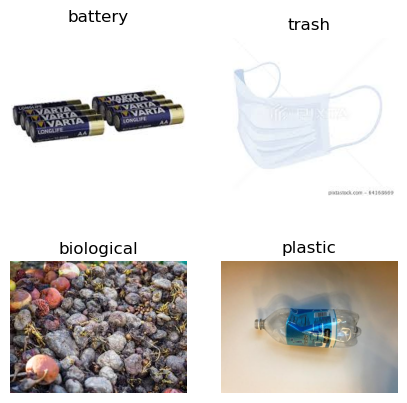

In [24]:
fig, axes = plt.subplots(2, 2, figsize = (5,5)) #выведем 4 изображения
axes = axes.ravel() 

for i in np.arange(0, 4): 

    category = random.choice(os.listdir(train_path)) #случайный выбор класса
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir)) #cлучайный выбор изображения из класса
 
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(category) 
    axes[i].axis('off')

Let's look at the distribution of data between classes.

In [25]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Trash: 667
Cardboard: 1864
Glass: 3272
Metal: 1494
Clothes: 4260
Plastic: 2013
Biological: 788
Shoes: 1581
Battery: 756
Paper: 2169

Total number of train images: 18864


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [26]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [27]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[756, 788, 1864, 4260, 3272, 1494, 2169, 2013, 1581, 667]

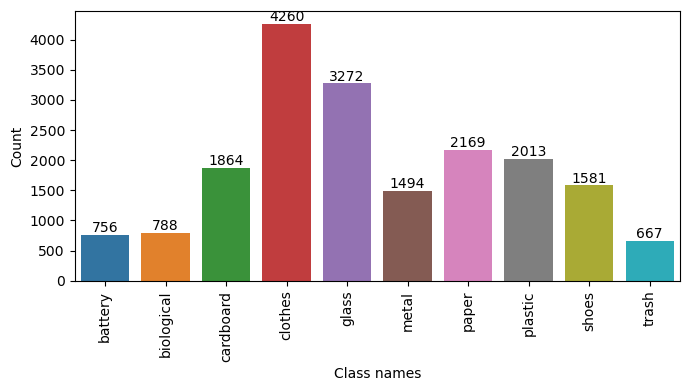

In [28]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

A situation where one or more classes contain a significantly larger number of images is called class imbalance. In our situation, it is natural and determined by the specifics of the data. Thus, there are many more varieties of clothing or glass objects than batteries. However, this may negatively affect the training results of the model and cause it to be biased towards the largest class (that is, it will be much worse at classifying smaller classes). There are different approaches to solving this problem, the applicability of which depends on the problem being solved. We will use the method of insufficient sampling (*random undersampling*), which consists of randomly excluding some examples from large classes.

Excluding some random images from the training data

In [29]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category)) 
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1
           
    print(f'Deleted {delete} in {category}')


Deleted 0 in trash
Deleted 864 in cardboard
Deleted 2272 in glass
Deleted 494 in metal
Deleted 3260 in clothes
Deleted 1013 in plastic
Deleted 0 in biological
Deleted 581 in shoes
Deleted 0 in battery
Deleted 1169 in paper


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now

In [30]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

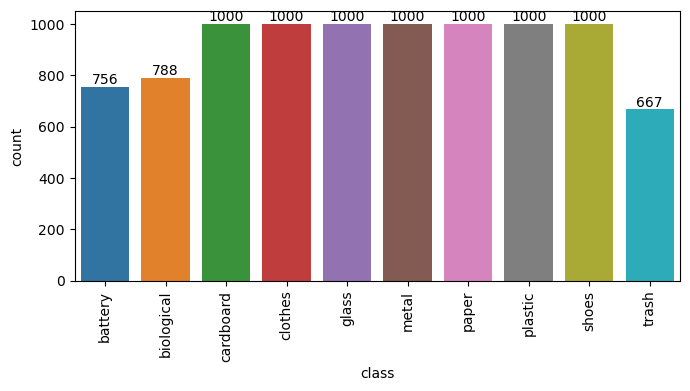

In [31]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [32]:
data_path = '/kaggle/working/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [33]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

[codecarbon INFO @ 01:23:04] Energy consumed for RAM : 0.000539 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:23:04] Energy consumed for all GPUs : 0.000898 kWh. Total GPU Power : 19.42848476170562 W
[codecarbon INFO @ 01:23:04] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:23:04] 0.003384 kWh of electricity used since the beginning.


Mean width: 415.2716
Mean Height: 395.8310


Let's set the size of the input data (image size) taking into account the found average values

In [34]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts

In [35]:
BATCH_SIZE = 32


Create a SummaryWriter instance to write logs

In [36]:
writer = SummaryWriter()

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.


In [37]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 9211 files belonging to 10 classes.


In [38]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 2366 files belonging to 10 classes.


In [39]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 2354 files belonging to 10 classes.


Create directories for train and test logs and write logs to it 

In [40]:
train_log_dir = os.path.join("logs", experiment_name, "train")
test_log_dir = os.path.join("logs", experiment_name, "test")

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)


In [41]:
prepare_data_emissions: float = prepare_data_emission_tracker.stop()
print(f"Prepare Data Carbon Emissions: {prepare_data_emissions} kg")

[codecarbon INFO @ 01:23:08] Energy consumed for RAM : 0.000552 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:23:08] Energy consumed for all GPUs : 0.000933 kWh. Total GPU Power : 30.39410024581175 W
[codecarbon INFO @ 01:23:08] Energy consumed for all CPUs : 0.001998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:23:08] 0.003484 kWh of electricity used since the beginning.


Prepare Data Carbon Emissions: 0.00048335066779677573 kg


# Building the model

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/).
For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the EfficientNetV2S model, which has 88 layers, was selected. Although the EfficientNetV2M and EfficientNetV2L models have higher accuracy, they have significantly higher weights.


In [42]:
develop_model_emission_tracker = EmissionsTracker()
develop_model_emission_tracker.start()

[codecarbon INFO @ 01:23:09] [setup] RAM Tracking...
[codecarbon INFO @ 01:23:09] [setup] GPU Tracking...
[codecarbon INFO @ 01:23:09] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:23:09] [setup] CPU Tracking...
[codecarbon WARNING @ 01:23:09] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 01:23:10] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 01:23:10] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 01:23:10] >>> Tracker's metadata:
[codecarbon INFO @ 01:23:10]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 01:23:10]   Python version: 3.10.10
[codecarbon INFO @ 01:23:10]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 01:23:10]   Available RAM : 31.358 GB
[codecarbon INFO @ 01:23:10]   CPU count: 4
[codecarbon INFO @ 01:23:10]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 01:23:10]   GPU

Loading the model

In [43]:
base_model = tf.keras.applications.EfficientNetV2S(include_top=False,
                                                   weights='imagenet', 
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

82420632/82420632 [==============================] - 0s 0us/step


Let's see what the architecture of the pretrained model looks like

In [44]:
base_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 400, 400, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 200, 200, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.ь.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [45]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [46]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2), 
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

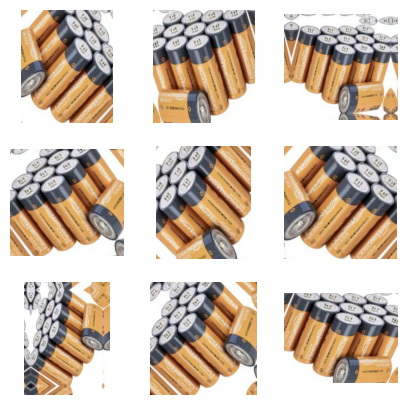

In [47]:
for image, _ in train_data.take(1):  
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

* GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
* A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
* Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [48]:
name="EfficientNetV2S"

EfficientNetV2S_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

For training, we will define a loss function, an optimizer, and a tracked accuracy metric

In [49]:
EfficientNetV2S_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model

In [50]:
EfficientNetV2S_model.summary()

Model: "EfficientNetV2S"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-s (Functiona  (None, 13, 13, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                   

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [51]:
# def log_to_tensorboard(epoch, logs):
#         train_writer.add_scalar('loss', logs['loss'], epoch)
#         train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
#         test_writer.add_scalar('val_loss', logs['val_loss'], epoch)
#         test_writer.add_scalar('val_accuracy', logs['val_accuracy'], epoch)
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
    
    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)
    
    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [52]:
EfficientNetV2S_callback = create_callback(name)

Let's set the number of training epochs

In [53]:
EPOCH=20

Let's train the model

In [54]:
import time
start_time = time.time()
EfficientNetV2S_history = EfficientNetV2S_model.fit(train_data, 
                                                    epochs=EPOCH, 
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data, 
                                                    validation_steps=len(validation_data),
                                                    callbacks=EfficientNetV2S_callback)

Epoch 1/20


[codecarbon INFO @ 01:23:43] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:23:43] Energy consumed for all GPUs : 0.000451 kWh. Total GPU Power : 54.598472161388926 W
[codecarbon INFO @ 01:23:43] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:23:43] 0.000904 kWh of electricity used since the beginning.
2024-01-20 01:23:46.044219: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  5/288 [..............................] - ETA: 6:52 - loss: 2.0496 - accuracy: 0.3000

[codecarbon INFO @ 01:23:58] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:23:58] Energy consumed for all GPUs : 0.000780 kWh. Total GPU Power : 79.02538049424282 W
[codecarbon INFO @ 01:23:58] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:23:58] 0.001459 kWh of electricity used since the beginning.


 15/288 [>.............................] - ETA: 6:52 - loss: 1.5834 - accuracy: 0.5562

[codecarbon INFO @ 01:24:13] Energy consumed for RAM : 0.000196 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:24:13] Energy consumed for all GPUs : 0.001189 kWh. Total GPU Power : 98.04908827152266 W
[codecarbon INFO @ 01:24:13] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:24:13] 0.002093 kWh of electricity used since the beginning.


 24/288 [=>............................] - ETA: 6:48 - loss: 1.3062 - accuracy: 0.6367

[codecarbon INFO @ 01:24:28] Energy consumed for RAM : 0.000245 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:24:28] Energy consumed for all GPUs : 0.001597 kWh. Total GPU Power : 98.0911457773731 W
[codecarbon INFO @ 01:24:28] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:24:28] 0.002728 kWh of electricity used since the beginning.


 33/288 [==>...........................] - ETA: 6:43 - loss: 1.1275 - accuracy: 0.6856

[codecarbon INFO @ 01:24:43] Energy consumed for RAM : 0.000294 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:24:43] Energy consumed for all GPUs : 0.002006 kWh. Total GPU Power : 98.1236616008666 W
[codecarbon INFO @ 01:24:43] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:24:43] 0.003362 kWh of electricity used since the beginning.


 43/288 [===>..........................] - ETA: 6:30 - loss: 1.0017 - accuracy: 0.7180

[codecarbon INFO @ 01:24:58] Energy consumed for RAM : 0.000343 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:24:58] Energy consumed for all GPUs : 0.002417 kWh. Total GPU Power : 98.73254963647332 W
[codecarbon INFO @ 01:24:58] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:24:58] 0.004000 kWh of electricity used since the beginning.


 52/288 [====>.........................] - ETA: 6:19 - loss: 0.9173 - accuracy: 0.7404

[codecarbon INFO @ 01:25:13] Energy consumed for RAM : 0.000392 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:25:13] Energy consumed for all GPUs : 0.002829 kWh. Total GPU Power : 98.7984211843489 W
[codecarbon INFO @ 01:25:13] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:25:13] 0.004637 kWh of electricity used since the beginning.


 60/288 [=====>........................] - ETA: 6:06 - loss: 0.8523 - accuracy: 0.7589

[codecarbon INFO @ 01:25:28] Energy consumed for RAM : 0.000441 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:25:28] Energy consumed for all GPUs : 0.003244 kWh. Total GPU Power : 99.62381029387662 W
[codecarbon INFO @ 01:25:28] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:25:28] 0.005278 kWh of electricity used since the beginning.


 70/288 [======>.......................] - ETA: 5:52 - loss: 0.7990 - accuracy: 0.7737

[codecarbon INFO @ 01:25:43] Energy consumed for RAM : 0.000490 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:25:43] Energy consumed for all GPUs : 0.003656 kWh. Total GPU Power : 98.91747828862745 W
[codecarbon INFO @ 01:25:43] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:25:43] 0.005916 kWh of electricity used since the beginning.


 80/288 [=======>......................] - ETA: 5:33 - loss: 0.7573 - accuracy: 0.7871

[codecarbon INFO @ 01:25:58] Energy consumed for RAM : 0.000539 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:25:58] Energy consumed for all GPUs : 0.004069 kWh. Total GPU Power : 99.22980041698969 W
[codecarbon INFO @ 01:25:58] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:25:58] 0.006555 kWh of electricity used since the beginning.


 89/288 [========>.....................] - ETA: 5:20 - loss: 0.7257 - accuracy: 0.7949

[codecarbon INFO @ 01:26:13] Energy consumed for RAM : 0.000588 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:26:13] Energy consumed for all GPUs : 0.004482 kWh. Total GPU Power : 99.28339281816086 W
[codecarbon INFO @ 01:26:13] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:26:13] 0.007195 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 5:04 - loss: 0.6899 - accuracy: 0.8055

[codecarbon INFO @ 01:26:28] Energy consumed for RAM : 0.000637 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:26:28] Energy consumed for all GPUs : 0.004896 kWh. Total GPU Power : 99.36083461500796 W
[codecarbon INFO @ 01:26:28] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:26:28] 0.007835 kWh of electricity used since the beginning.


108/288 [==========>...................] - ETA: 4:48 - loss: 0.6651 - accuracy: 0.8111

[codecarbon INFO @ 01:26:43] Energy consumed for RAM : 0.000686 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:26:43] Energy consumed for all GPUs : 0.005312 kWh. Total GPU Power : 99.77765757622068 W
[codecarbon INFO @ 01:26:43] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:26:43] 0.008476 kWh of electricity used since the beginning.


116/288 [===========>..................] - ETA: 4:37 - loss: 0.6437 - accuracy: 0.8165

[codecarbon INFO @ 01:26:58] Energy consumed for RAM : 0.000735 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:26:58] Energy consumed for all GPUs : 0.005729 kWh. Total GPU Power : 100.3316951621748 W
[codecarbon INFO @ 01:26:58] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:26:58] 0.009120 kWh of electricity used since the beginning.


125/288 [============>.................] - ETA: 4:24 - loss: 0.6235 - accuracy: 0.8227

[codecarbon INFO @ 01:27:13] Energy consumed for RAM : 0.000783 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:27:13] Energy consumed for all GPUs : 0.006146 kWh. Total GPU Power : 99.9822962020807 W
[codecarbon INFO @ 01:27:13] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:27:13] 0.009762 kWh of electricity used since the beginning.


135/288 [=============>................] - ETA: 4:06 - loss: 0.6044 - accuracy: 0.8273

[codecarbon INFO @ 01:27:28] Energy consumed for RAM : 0.000832 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:27:28] Energy consumed for all GPUs : 0.006562 kWh. Total GPU Power : 100.00290569860115 W
[codecarbon INFO @ 01:27:28] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:27:28] 0.010405 kWh of electricity used since the beginning.


145/288 [==============>...............] - ETA: 3:50 - loss: 0.5886 - accuracy: 0.8321

[codecarbon INFO @ 01:27:43] Energy consumed for RAM : 0.000881 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:27:43] Energy consumed for all GPUs : 0.006980 kWh. Total GPU Power : 100.2520798754835 W
[codecarbon INFO @ 01:27:43] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:27:43] 0.011049 kWh of electricity used since the beginning.


155/288 [===============>..............] - ETA: 3:33 - loss: 0.5705 - accuracy: 0.8351

[codecarbon INFO @ 01:27:58] Energy consumed for RAM : 0.000930 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:27:58] Energy consumed for all GPUs : 0.007397 kWh. Total GPU Power : 100.13845520688177 W
[codecarbon INFO @ 01:27:58] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:27:58] 0.011693 kWh of electricity used since the beginning.


164/288 [================>.............] - ETA: 3:19 - loss: 0.5555 - accuracy: 0.8397

[codecarbon INFO @ 01:28:13] Energy consumed for RAM : 0.000979 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:28:13] Energy consumed for all GPUs : 0.007818 kWh. Total GPU Power : 101.06149874316681 W
[codecarbon INFO @ 01:28:13] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:28:13] 0.012339 kWh of electricity used since the beginning.


173/288 [=================>............] - ETA: 3:05 - loss: 0.5425 - accuracy: 0.8438

[codecarbon INFO @ 01:28:28] Energy consumed for RAM : 0.001028 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:28:28] Energy consumed for all GPUs : 0.008237 kWh. Total GPU Power : 100.69518076614668 W
[codecarbon INFO @ 01:28:28] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:28:28] 0.012985 kWh of electricity used since the beginning.


183/288 [==================>...........] - ETA: 2:48 - loss: 0.5343 - accuracy: 0.8444

[codecarbon INFO @ 01:28:43] Energy consumed for RAM : 0.001077 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:28:43] Energy consumed for all GPUs : 0.008656 kWh. Total GPU Power : 100.6069348862485 W
[codecarbon INFO @ 01:28:43] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:28:43] 0.013629 kWh of electricity used since the beginning.


191/288 [==================>...........] - ETA: 2:36 - loss: 0.5284 - accuracy: 0.8455

[codecarbon INFO @ 01:28:58] Energy consumed for RAM : 0.001126 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:28:58] Energy consumed for all GPUs : 0.009077 kWh. Total GPU Power : 100.92874102029637 W
[codecarbon INFO @ 01:28:58] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:28:58] 0.014276 kWh of electricity used since the beginning.


200/288 [===================>..........] - ETA: 2:21 - loss: 0.5202 - accuracy: 0.8477

[codecarbon INFO @ 01:29:13] Energy consumed for RAM : 0.001175 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:29:13] Energy consumed for all GPUs : 0.009496 kWh. Total GPU Power : 100.74160435868973 W
[codecarbon INFO @ 01:29:13] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:29:13] 0.014922 kWh of electricity used since the beginning.


211/288 [====================>.........] - ETA: 2:03 - loss: 0.5080 - accuracy: 0.8507

[codecarbon INFO @ 01:29:28] Energy consumed for RAM : 0.001224 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:29:28] Energy consumed for all GPUs : 0.009918 kWh. Total GPU Power : 101.18224334365718 W
[codecarbon INFO @ 01:29:28] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:29:28] 0.015569 kWh of electricity used since the beginning.


221/288 [======================>.......] - ETA: 1:47 - loss: 0.4991 - accuracy: 0.8529

[codecarbon INFO @ 01:29:43] Energy consumed for RAM : 0.001273 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:29:43] Energy consumed for all GPUs : 0.010340 kWh. Total GPU Power : 101.49981908516773 W
[codecarbon INFO @ 01:29:43] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:29:43] 0.016218 kWh of electricity used since the beginning.


230/288 [======================>.......] - ETA: 1:32 - loss: 0.4959 - accuracy: 0.8531

[codecarbon INFO @ 01:29:58] Energy consumed for RAM : 0.001322 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:29:58] Energy consumed for all GPUs : 0.010762 kWh. Total GPU Power : 101.29970449566595 W
[codecarbon INFO @ 01:29:58] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:29:58] 0.016866 kWh of electricity used since the beginning.


240/288 [========================>.....] - ETA: 1:16 - loss: 0.4888 - accuracy: 0.8539

[codecarbon INFO @ 01:30:13] Energy consumed for RAM : 0.001371 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:30:13] Energy consumed for all GPUs : 0.011184 kWh. Total GPU Power : 101.27484551304178 W
[codecarbon INFO @ 01:30:13] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:30:13] 0.017513 kWh of electricity used since the beginning.


249/288 [========================>.....] - ETA: 1:02 - loss: 0.4836 - accuracy: 0.8550

[codecarbon INFO @ 01:30:28] Energy consumed for RAM : 0.001420 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:30:28] Energy consumed for all GPUs : 0.011607 kWh. Total GPU Power : 101.56482512429247 W
[codecarbon INFO @ 01:30:28] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:30:28] 0.018162 kWh of electricity used since the beginning.


259/288 [=========================>....] - ETA: 46s - loss: 0.4775 - accuracy: 0.8569

[codecarbon INFO @ 01:30:43] Energy consumed for RAM : 0.001469 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:30:43] Energy consumed for all GPUs : 0.012029 kWh. Total GPU Power : 101.47750714245696 W
[codecarbon INFO @ 01:30:43] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:30:43] 0.018811 kWh of electricity used since the beginning.


269/288 [===========================>..] - ETA: 30s - loss: 0.4678 - accuracy: 0.8597

[codecarbon INFO @ 01:30:58] Energy consumed for RAM : 0.001518 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:30:58] Energy consumed for all GPUs : 0.012452 kWh. Total GPU Power : 101.43478897313138 W
[codecarbon INFO @ 01:30:58] Energy consumed for all CPUs : 0.005490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:30:58] 0.019459 kWh of electricity used since the beginning.


279/288 [============================>.] - ETA: 14s - loss: 0.4597 - accuracy: 0.8621

[codecarbon INFO @ 01:31:13] Energy consumed for RAM : 0.001567 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:31:13] Energy consumed for all GPUs : 0.012878 kWh. Total GPU Power : 102.25684408627706 W
[codecarbon INFO @ 01:31:13] Energy consumed for all CPUs : 0.005667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:31:13] 0.020111 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.8629

[codecarbon INFO @ 01:31:28] Energy consumed for RAM : 0.001616 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:31:28] Energy consumed for all GPUs : 0.013290 kWh. Total GPU Power : 98.89879813628428 W
[codecarbon INFO @ 01:31:28] Energy consumed for all CPUs : 0.005844 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:31:28] 0.020749 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:31:43] Energy consumed for RAM : 0.001665 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:31:43] Energy consumed for all GPUs : 0.013689 kWh. Total GPU Power : 95.88368689671273 W
[codecarbon INFO @ 01:31:43] Energy consumed for all CPUs : 0.006021 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:31:43] 0.021374 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:31:58] Energy consumed for RAM : 0.001714 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:31:58] Energy consumed for all GPUs : 0.014113 kWh. Total GPU Power : 101.7883911766

288/288 [==============================] - 511s 2s/step - loss: 0.4556 - accuracy: 0.8629 - val_loss: 0.1817 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 2/20
  6/288 [..............................] - ETA: 7:59 - loss: 0.2873 - accuracy: 0.8958

[codecarbon INFO @ 01:32:13] Energy consumed for RAM : 0.001763 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:32:13] Energy consumed for all GPUs : 0.014530 kWh. Total GPU Power : 100.36583561294432 W
[codecarbon INFO @ 01:32:13] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:32:13] 0.022668 kWh of electricity used since the beginning.


 15/288 [>.............................] - ETA: 7:19 - loss: 0.2694 - accuracy: 0.9000

[codecarbon INFO @ 01:32:28] Energy consumed for RAM : 0.001812 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:32:28] Energy consumed for all GPUs : 0.014956 kWh. Total GPU Power : 102.07472953579494 W
[codecarbon INFO @ 01:32:28] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:32:28] 0.023319 kWh of electricity used since the beginning.


 25/288 [=>............................] - ETA: 7:09 - loss: 0.2341 - accuracy: 0.9175

[codecarbon INFO @ 01:32:43] Energy consumed for RAM : 0.001861 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:32:43] Energy consumed for all GPUs : 0.015382 kWh. Total GPU Power : 102.29257223966867 W
[codecarbon INFO @ 01:32:43] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:32:43] 0.023971 kWh of electricity used since the beginning.


 36/288 [==>...........................] - ETA: 6:23 - loss: 0.2673 - accuracy: 0.9132

[codecarbon INFO @ 01:32:58] Energy consumed for RAM : 0.001910 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:32:58] Energy consumed for all GPUs : 0.015807 kWh. Total GPU Power : 102.2437432388589 W
[codecarbon INFO @ 01:32:58] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:32:58] 0.024623 kWh of electricity used since the beginning.


 47/288 [===>..........................] - ETA: 6:01 - loss: 0.2651 - accuracy: 0.9122

[codecarbon INFO @ 01:33:13] Energy consumed for RAM : 0.001959 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:33:13] Energy consumed for all GPUs : 0.016234 kWh. Total GPU Power : 102.33797220965116 W
[codecarbon INFO @ 01:33:13] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:33:13] 0.025276 kWh of electricity used since the beginning.


 57/288 [====>.........................] - ETA: 5:45 - loss: 0.2670 - accuracy: 0.9134

[codecarbon INFO @ 01:33:28] Energy consumed for RAM : 0.002008 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:33:28] Energy consumed for all GPUs : 0.016661 kWh. Total GPU Power : 102.60504080462563 W
[codecarbon INFO @ 01:33:28] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:33:28] 0.025929 kWh of electricity used since the beginning.


 68/288 [======>.......................] - ETA: 5:24 - loss: 0.2719 - accuracy: 0.9131

[codecarbon INFO @ 01:33:43] Energy consumed for RAM : 0.002057 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:33:43] Energy consumed for all GPUs : 0.017087 kWh. Total GPU Power : 102.36737860870839 W
[codecarbon INFO @ 01:33:43] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:33:43] 0.026581 kWh of electricity used since the beginning.


 79/288 [=======>......................] - ETA: 5:05 - loss: 0.2773 - accuracy: 0.9106

[codecarbon INFO @ 01:33:58] Energy consumed for RAM : 0.002106 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:33:58] Energy consumed for all GPUs : 0.017515 kWh. Total GPU Power : 102.63188512951815 W
[codecarbon INFO @ 01:33:58] Energy consumed for all CPUs : 0.007615 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:33:58] 0.027235 kWh of electricity used since the beginning.


 89/288 [========>.....................] - ETA: 4:52 - loss: 0.2807 - accuracy: 0.9108

[codecarbon INFO @ 01:34:13] Energy consumed for RAM : 0.002154 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:34:13] Energy consumed for all GPUs : 0.017941 kWh. Total GPU Power : 102.53742839254495 W
[codecarbon INFO @ 01:34:13] Energy consumed for all CPUs : 0.007792 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:34:13] 0.027887 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 4:39 - loss: 0.2749 - accuracy: 0.9120

[codecarbon INFO @ 01:34:28] Energy consumed for RAM : 0.002203 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:34:28] Energy consumed for all GPUs : 0.018369 kWh. Total GPU Power : 102.70531885245526 W
[codecarbon INFO @ 01:34:28] Energy consumed for all CPUs : 0.007969 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:34:28] 0.028541 kWh of electricity used since the beginning.


108/288 [==========>...................] - ETA: 4:25 - loss: 0.2706 - accuracy: 0.9129

[codecarbon INFO @ 01:34:43] Energy consumed for RAM : 0.002252 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:34:43] Energy consumed for all GPUs : 0.018795 kWh. Total GPU Power : 102.3600031522038 W
[codecarbon INFO @ 01:34:43] Energy consumed for all CPUs : 0.008146 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:34:43] 0.029193 kWh of electricity used since the beginning.


118/288 [===========>..................] - ETA: 4:11 - loss: 0.2714 - accuracy: 0.9121

[codecarbon INFO @ 01:34:58] Energy consumed for RAM : 0.002301 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:34:58] Energy consumed for all GPUs : 0.019224 kWh. Total GPU Power : 102.80280688388373 W
[codecarbon INFO @ 01:34:58] Energy consumed for all CPUs : 0.008323 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:34:58] 0.029848 kWh of electricity used since the beginning.


128/288 [============>.................] - ETA: 3:57 - loss: 0.2701 - accuracy: 0.9116

[codecarbon INFO @ 01:35:13] Energy consumed for RAM : 0.002350 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:35:13] Energy consumed for all GPUs : 0.019651 kWh. Total GPU Power : 102.67541178339742 W
[codecarbon INFO @ 01:35:13] Energy consumed for all CPUs : 0.008500 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:35:13] 0.030501 kWh of electricity used since the beginning.


138/288 [=============>................] - ETA: 3:41 - loss: 0.2682 - accuracy: 0.9133

[codecarbon INFO @ 01:35:28] Energy consumed for RAM : 0.002399 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:35:28] Energy consumed for all GPUs : 0.020078 kWh. Total GPU Power : 102.37839507557021 W
[codecarbon INFO @ 01:35:28] Energy consumed for all CPUs : 0.008677 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:35:28] 0.031154 kWh of electricity used since the beginning.


149/288 [==============>...............] - ETA: 3:25 - loss: 0.2673 - accuracy: 0.9138

[codecarbon INFO @ 01:35:43] Energy consumed for RAM : 0.002448 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:35:43] Energy consumed for all GPUs : 0.020505 kWh. Total GPU Power : 102.6096769888804 W
[codecarbon INFO @ 01:35:43] Energy consumed for all CPUs : 0.008854 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:35:43] 0.031807 kWh of electricity used since the beginning.


159/288 [===============>..............] - ETA: 3:10 - loss: 0.2660 - accuracy: 0.9149

[codecarbon INFO @ 01:35:58] Energy consumed for RAM : 0.002497 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:35:58] Energy consumed for all GPUs : 0.020931 kWh. Total GPU Power : 102.3992942710138 W
[codecarbon INFO @ 01:35:58] Energy consumed for all CPUs : 0.009031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:35:58] 0.032460 kWh of electricity used since the beginning.


170/288 [================>.............] - ETA: 2:53 - loss: 0.2608 - accuracy: 0.9167

[codecarbon INFO @ 01:36:13] Energy consumed for RAM : 0.002546 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:36:13] Energy consumed for all GPUs : 0.021359 kWh. Total GPU Power : 102.56244864977525 W
[codecarbon INFO @ 01:36:13] Energy consumed for all CPUs : 0.009208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:36:13] 0.033113 kWh of electricity used since the beginning.


180/288 [=================>............] - ETA: 2:39 - loss: 0.2615 - accuracy: 0.9165

[codecarbon INFO @ 01:36:28] Energy consumed for RAM : 0.002595 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:36:28] Energy consumed for all GPUs : 0.021789 kWh. Total GPU Power : 103.27465862212 W
[codecarbon INFO @ 01:36:28] Energy consumed for all CPUs : 0.009385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:36:28] 0.033769 kWh of electricity used since the beginning.


190/288 [==================>...........] - ETA: 2:24 - loss: 0.2615 - accuracy: 0.9156

[codecarbon INFO @ 01:36:43] Energy consumed for RAM : 0.002644 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:36:43] Energy consumed for all GPUs : 0.022215 kWh. Total GPU Power : 102.51410611653932 W
[codecarbon INFO @ 01:36:43] Energy consumed for all CPUs : 0.009562 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:36:43] 0.034422 kWh of electricity used since the beginning.


200/288 [===================>..........] - ETA: 2:09 - loss: 0.2580 - accuracy: 0.9167

[codecarbon INFO @ 01:36:58] Energy consumed for RAM : 0.002693 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:36:58] Energy consumed for all GPUs : 0.022643 kWh. Total GPU Power : 102.79956071039717 W
[codecarbon INFO @ 01:36:58] Energy consumed for all CPUs : 0.009739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:36:58] 0.035076 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 1:49 - loss: 0.2565 - accuracy: 0.9171

[codecarbon INFO @ 01:37:13] Energy consumed for RAM : 0.002742 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:37:13] Energy consumed for all GPUs : 0.023071 kWh. Total GPU Power : 102.62412580704977 W
[codecarbon INFO @ 01:37:13] Energy consumed for all CPUs : 0.009916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:37:13] 0.035729 kWh of electricity used since the beginning.


223/288 [======================>.......] - ETA: 1:34 - loss: 0.2566 - accuracy: 0.9169

[codecarbon INFO @ 01:37:28] Energy consumed for RAM : 0.002791 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:37:28] Energy consumed for all GPUs : 0.023499 kWh. Total GPU Power : 102.67564158165291 W
[codecarbon INFO @ 01:37:28] Energy consumed for all CPUs : 0.010093 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:37:28] 0.036383 kWh of electricity used since the beginning.


232/288 [=======================>......] - ETA: 1:21 - loss: 0.2557 - accuracy: 0.9166

[codecarbon INFO @ 01:37:43] Energy consumed for RAM : 0.002840 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:37:43] Energy consumed for all GPUs : 0.023927 kWh. Total GPU Power : 102.91597172954611 W
[codecarbon INFO @ 01:37:43] Energy consumed for all CPUs : 0.010270 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:37:43] 0.037037 kWh of electricity used since the beginning.


245/288 [========================>.....] - ETA: 1:02 - loss: 0.2558 - accuracy: 0.9170

[codecarbon INFO @ 01:37:58] Energy consumed for RAM : 0.002889 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:37:58] Energy consumed for all GPUs : 0.024354 kWh. Total GPU Power : 102.54106764988263 W
[codecarbon INFO @ 01:37:58] Energy consumed for all CPUs : 0.010447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:37:58] 0.037691 kWh of electricity used since the beginning.


256/288 [=========================>....] - ETA: 46s - loss: 0.2573 - accuracy: 0.9171

[codecarbon INFO @ 01:38:13] Energy consumed for RAM : 0.002938 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:38:13] Energy consumed for all GPUs : 0.024784 kWh. Total GPU Power : 103.2632561859887 W
[codecarbon INFO @ 01:38:13] Energy consumed for all CPUs : 0.010625 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:38:13] 0.038347 kWh of electricity used since the beginning.


267/288 [==========================>...] - ETA: 30s - loss: 0.2560 - accuracy: 0.9182

[codecarbon INFO @ 01:38:28] Energy consumed for RAM : 0.002987 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:38:28] Energy consumed for all GPUs : 0.025212 kWh. Total GPU Power : 102.6689852113 W
[codecarbon INFO @ 01:38:28] Energy consumed for all CPUs : 0.010802 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:38:28] 0.039000 kWh of electricity used since the beginning.


276/288 [===========================>..] - ETA: 17s - loss: 0.2560 - accuracy: 0.9180

[codecarbon INFO @ 01:38:43] Energy consumed for RAM : 0.003036 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:38:43] Energy consumed for all GPUs : 0.025641 kWh. Total GPU Power : 103.12806416574668 W
[codecarbon INFO @ 01:38:43] Energy consumed for all CPUs : 0.010979 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:38:43] 0.039656 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2568 - accuracy: 0.9179

[codecarbon INFO @ 01:38:58] Energy consumed for RAM : 0.003085 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:38:58] Energy consumed for all GPUs : 0.026065 kWh. Total GPU Power : 101.78555520798815 W
[codecarbon INFO @ 01:38:58] Energy consumed for all CPUs : 0.011156 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:38:58] 0.040306 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:39:13] Energy consumed for RAM : 0.003134 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:39:13] Energy consumed for all GPUs : 0.026492 kWh. Total GPU Power : 102.498534421689 W
[codecarbon INFO @ 01:39:13] Energy consumed for all CPUs : 0.011333 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:39:13] 0.040959 kWh of electricity used since the beginning.


288/288 [==============================] - 443s 2s/step - loss: 0.2568 - accuracy: 0.9179 - val_loss: 0.1698 - val_accuracy: 0.9486 - lr: 0.0010
Epoch 3/20
  1/288 [..............................] - ETA: 8:35 - loss: 0.2025 - accuracy: 0.9062

[codecarbon INFO @ 01:39:28] Energy consumed for RAM : 0.003183 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:39:28] Energy consumed for all GPUs : 0.026913 kWh. Total GPU Power : 101.07548765231537 W
[codecarbon INFO @ 01:39:28] Energy consumed for all CPUs : 0.011510 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:39:28] 0.041606 kWh of electricity used since the beginning.


 12/288 [>.............................] - ETA: 6:28 - loss: 0.2530 - accuracy: 0.8958

[codecarbon INFO @ 01:39:43] Energy consumed for RAM : 0.003232 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:39:43] Energy consumed for all GPUs : 0.027341 kWh. Total GPU Power : 102.89414590462768 W
[codecarbon INFO @ 01:39:43] Energy consumed for all CPUs : 0.011687 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:39:43] 0.042260 kWh of electricity used since the beginning.


 24/288 [=>............................] - ETA: 5:47 - loss: 0.2194 - accuracy: 0.9167

[codecarbon INFO @ 01:39:58] Energy consumed for RAM : 0.003281 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:39:58] Energy consumed for all GPUs : 0.027770 kWh. Total GPU Power : 102.96950774487394 W
[codecarbon INFO @ 01:39:58] Energy consumed for all CPUs : 0.011864 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:39:58] 0.042915 kWh of electricity used since the beginning.


 36/288 [==>...........................] - ETA: 5:28 - loss: 0.2378 - accuracy: 0.9184

[codecarbon INFO @ 01:40:13] Energy consumed for RAM : 0.003330 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:40:13] Energy consumed for all GPUs : 0.028199 kWh. Total GPU Power : 102.90498068414584 W
[codecarbon INFO @ 01:40:13] Energy consumed for all CPUs : 0.012041 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:40:13] 0.043569 kWh of electricity used since the beginning.


 47/288 [===>..........................] - ETA: 5:18 - loss: 0.2294 - accuracy: 0.9249

[codecarbon INFO @ 01:40:28] Energy consumed for RAM : 0.003379 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:40:28] Energy consumed for all GPUs : 0.028628 kWh. Total GPU Power : 103.05210533642565 W
[codecarbon INFO @ 01:40:28] Energy consumed for all CPUs : 0.012218 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:40:28] 0.044225 kWh of electricity used since the beginning.


 57/288 [====>.........................] - ETA: 5:12 - loss: 0.2301 - accuracy: 0.9249

[codecarbon INFO @ 01:40:43] Energy consumed for RAM : 0.003428 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:40:43] Energy consumed for all GPUs : 0.029056 kWh. Total GPU Power : 102.80274741305749 W
[codecarbon INFO @ 01:40:43] Energy consumed for all CPUs : 0.012395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:40:43] 0.044879 kWh of electricity used since the beginning.


 67/288 [=====>........................] - ETA: 5:01 - loss: 0.2252 - accuracy: 0.9272

[codecarbon INFO @ 01:40:58] Energy consumed for RAM : 0.003477 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:40:58] Energy consumed for all GPUs : 0.029486 kWh. Total GPU Power : 103.185470627211 W
[codecarbon INFO @ 01:40:58] Energy consumed for all CPUs : 0.012572 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:40:58] 0.045535 kWh of electricity used since the beginning.


 80/288 [=======>......................] - ETA: 4:37 - loss: 0.2307 - accuracy: 0.9250

[codecarbon INFO @ 01:41:13] Energy consumed for RAM : 0.003525 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:41:13] Energy consumed for all GPUs : 0.029916 kWh. Total GPU Power : 103.32079636221145 W
[codecarbon INFO @ 01:41:13] Energy consumed for all CPUs : 0.012749 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:41:13] 0.046191 kWh of electricity used since the beginning.


 90/288 [========>.....................] - ETA: 4:26 - loss: 0.2289 - accuracy: 0.9243

[codecarbon INFO @ 01:41:28] Energy consumed for RAM : 0.003574 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:41:28] Energy consumed for all GPUs : 0.030345 kWh. Total GPU Power : 102.93893593322562 W
[codecarbon INFO @ 01:41:28] Energy consumed for all CPUs : 0.012926 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:41:28] 0.046846 kWh of electricity used since the beginning.


103/288 [=========>....................] - ETA: 4:04 - loss: 0.2222 - accuracy: 0.9257

[codecarbon INFO @ 01:41:43] Energy consumed for RAM : 0.003623 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:41:43] Energy consumed for all GPUs : 0.030774 kWh. Total GPU Power : 102.97341176047651 W
[codecarbon INFO @ 01:41:43] Energy consumed for all CPUs : 0.013104 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:41:43] 0.047501 kWh of electricity used since the beginning.


116/288 [===========>..................] - ETA: 3:45 - loss: 0.2213 - accuracy: 0.9267

[codecarbon INFO @ 01:41:58] Energy consumed for RAM : 0.003672 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:41:58] Energy consumed for all GPUs : 0.031202 kWh. Total GPU Power : 102.76382676383334 W
[codecarbon INFO @ 01:41:58] Energy consumed for all CPUs : 0.013281 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:41:58] 0.048155 kWh of electricity used since the beginning.


127/288 [============>.................] - ETA: 3:31 - loss: 0.2169 - accuracy: 0.9281

[codecarbon INFO @ 01:42:13] Energy consumed for RAM : 0.003721 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:42:13] Energy consumed for all GPUs : 0.031631 kWh. Total GPU Power : 103.06808947025814 W
[codecarbon INFO @ 01:42:13] Energy consumed for all CPUs : 0.013458 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:42:13] 0.048810 kWh of electricity used since the beginning.


141/288 [=============>................] - ETA: 3:08 - loss: 0.2168 - accuracy: 0.9280

[codecarbon INFO @ 01:42:28] Energy consumed for RAM : 0.003770 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:42:28] Energy consumed for all GPUs : 0.032059 kWh. Total GPU Power : 102.8753201144135 W
[codecarbon INFO @ 01:42:28] Energy consumed for all CPUs : 0.013635 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:42:28] 0.049464 kWh of electricity used since the beginning.


153/288 [==============>...............] - ETA: 2:53 - loss: 0.2110 - accuracy: 0.9299

[codecarbon INFO @ 01:42:43] Energy consumed for RAM : 0.003819 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:42:43] Energy consumed for all GPUs : 0.032490 kWh. Total GPU Power : 103.55211803461648 W
[codecarbon INFO @ 01:42:43] Energy consumed for all CPUs : 0.013812 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:42:43] 0.050122 kWh of electricity used since the beginning.


163/288 [===============>..............] - ETA: 2:42 - loss: 0.2118 - accuracy: 0.9291

[codecarbon INFO @ 01:42:58] Energy consumed for RAM : 0.003868 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:42:58] Energy consumed for all GPUs : 0.032919 kWh. Total GPU Power : 102.89814853931715 W
[codecarbon INFO @ 01:42:58] Energy consumed for all CPUs : 0.013989 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:42:58] 0.050776 kWh of electricity used since the beginning.


173/288 [=================>............] - ETA: 2:30 - loss: 0.2098 - accuracy: 0.9290

[codecarbon INFO @ 01:43:13] Energy consumed for RAM : 0.003917 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:43:13] Energy consumed for all GPUs : 0.033349 kWh. Total GPU Power : 103.22466248368048 W
[codecarbon INFO @ 01:43:13] Energy consumed for all CPUs : 0.014166 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:43:13] 0.051432 kWh of electricity used since the beginning.


185/288 [==================>...........] - ETA: 2:14 - loss: 0.2123 - accuracy: 0.9284

[codecarbon INFO @ 01:43:28] Energy consumed for RAM : 0.003966 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:43:28] Energy consumed for all GPUs : 0.033777 kWh. Total GPU Power : 102.77910721236236 W
[codecarbon INFO @ 01:43:28] Energy consumed for all CPUs : 0.014343 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:43:28] 0.052086 kWh of electricity used since the beginning.


194/288 [===================>..........] - ETA: 2:03 - loss: 0.2157 - accuracy: 0.9277

[codecarbon INFO @ 01:43:43] Energy consumed for RAM : 0.004015 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:43:43] Energy consumed for all GPUs : 0.034207 kWh. Total GPU Power : 103.15160311894617 W
[codecarbon INFO @ 01:43:43] Energy consumed for all CPUs : 0.014520 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:43:43] 0.052742 kWh of electricity used since the beginning.


204/288 [====================>.........] - ETA: 1:51 - loss: 0.2148 - accuracy: 0.9283

[codecarbon INFO @ 01:43:58] Energy consumed for RAM : 0.004064 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:43:58] Energy consumed for all GPUs : 0.034635 kWh. Total GPU Power : 102.85866652826685 W
[codecarbon INFO @ 01:43:58] Energy consumed for all CPUs : 0.014697 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:43:58] 0.053396 kWh of electricity used since the beginning.


214/288 [=====================>........] - ETA: 1:38 - loss: 0.2155 - accuracy: 0.9282

[codecarbon INFO @ 01:44:13] Energy consumed for RAM : 0.004113 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:44:13] Energy consumed for all GPUs : 0.035065 kWh. Total GPU Power : 103.31164423253202 W
[codecarbon INFO @ 01:44:13] Energy consumed for all CPUs : 0.014874 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:44:13] 0.054052 kWh of electricity used since the beginning.


225/288 [======================>.......] - ETA: 1:24 - loss: 0.2141 - accuracy: 0.9290

[codecarbon INFO @ 01:44:28] Energy consumed for RAM : 0.004162 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:44:28] Energy consumed for all GPUs : 0.035496 kWh. Total GPU Power : 103.4612433497768 W
[codecarbon INFO @ 01:44:28] Energy consumed for all CPUs : 0.015051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:44:28] 0.054709 kWh of electricity used since the beginning.


236/288 [=======================>......] - ETA: 1:09 - loss: 0.2132 - accuracy: 0.9293

[codecarbon INFO @ 01:44:43] Energy consumed for RAM : 0.004211 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:44:43] Energy consumed for all GPUs : 0.035925 kWh. Total GPU Power : 102.8929047301144 W
[codecarbon INFO @ 01:44:43] Energy consumed for all CPUs : 0.015228 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:44:43] 0.055364 kWh of electricity used since the beginning.


247/288 [========================>.....] - ETA: 55s - loss: 0.2111 - accuracy: 0.9304

[codecarbon INFO @ 01:44:58] Energy consumed for RAM : 0.004260 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:44:58] Energy consumed for all GPUs : 0.036355 kWh. Total GPU Power : 103.29059925350909 W
[codecarbon INFO @ 01:44:58] Energy consumed for all CPUs : 0.015405 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:44:58] 0.056020 kWh of electricity used since the beginning.


259/288 [=========================>....] - ETA: 38s - loss: 0.2086 - accuracy: 0.9317

[codecarbon INFO @ 01:45:13] Energy consumed for RAM : 0.004309 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:45:13] Energy consumed for all GPUs : 0.036783 kWh. Total GPU Power : 102.90088720338078 W
[codecarbon INFO @ 01:45:13] Energy consumed for all CPUs : 0.015582 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:13] 0.056675 kWh of electricity used since the beginning.


270/288 [===========================>..] - ETA: 24s - loss: 0.2080 - accuracy: 0.9317

[codecarbon INFO @ 01:45:28] Energy consumed for RAM : 0.004358 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:45:28] Energy consumed for all GPUs : 0.037214 kWh. Total GPU Power : 103.2973168897211 W
[codecarbon INFO @ 01:45:28] Energy consumed for all CPUs : 0.015760 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:28] 0.057331 kWh of electricity used since the beginning.


281/288 [============================>.] - ETA: 9s - loss: 0.2080 - accuracy: 0.9316 

[codecarbon INFO @ 01:45:43] Energy consumed for RAM : 0.004407 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:45:43] Energy consumed for all GPUs : 0.037643 kWh. Total GPU Power : 102.97630627492612 W
[codecarbon INFO @ 01:45:43] Energy consumed for all CPUs : 0.015937 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:43] 0.057986 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9327

[codecarbon INFO @ 01:45:58] Energy consumed for RAM : 0.004456 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:45:58] Energy consumed for all GPUs : 0.038070 kWh. Total GPU Power : 102.6186359626666 W
[codecarbon INFO @ 01:45:58] Energy consumed for all CPUs : 0.016114 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:58] 0.058639 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:46:13] Energy consumed for RAM : 0.004505 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:46:13] Energy consumed for all GPUs : 0.038500 kWh. Total GPU Power : 103.28490041593038 W
[codecarbon INFO @ 01:46:13] Energy consumed for all CPUs : 0.016291 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:13] 0.059296 kWh of electricity used since the beginning.


288/288 [==============================] - 413s 1s/step - loss: 0.2053 - accuracy: 0.9327 - val_loss: 0.1587 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 4/20
  6/288 [..............................] - ETA: 7:05 - loss: 0.2848 - accuracy: 0.9010

[codecarbon INFO @ 01:46:28] Energy consumed for RAM : 0.004554 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:46:28] Energy consumed for all GPUs : 0.038920 kWh. Total GPU Power : 100.78910344127033 W
[codecarbon INFO @ 01:46:28] Energy consumed for all CPUs : 0.016468 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:28] 0.059941 kWh of electricity used since the beginning.


 19/288 [>.............................] - ETA: 5:41 - loss: 0.2035 - accuracy: 0.9293

[codecarbon INFO @ 01:46:43] Energy consumed for RAM : 0.004603 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:46:43] Energy consumed for all GPUs : 0.039350 kWh. Total GPU Power : 103.2997281303705 W
[codecarbon INFO @ 01:46:43] Energy consumed for all CPUs : 0.016645 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:43] 0.060598 kWh of electricity used since the beginning.


 31/288 [==>...........................] - ETA: 5:15 - loss: 0.1943 - accuracy: 0.9345

[codecarbon INFO @ 01:46:58] Energy consumed for RAM : 0.004652 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:46:58] Energy consumed for all GPUs : 0.039780 kWh. Total GPU Power : 103.44402870530621 W
[codecarbon INFO @ 01:46:58] Energy consumed for all CPUs : 0.016822 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:58] 0.061253 kWh of electricity used since the beginning.


 43/288 [===>..........................] - ETA: 4:59 - loss: 0.2021 - accuracy: 0.9375

[codecarbon INFO @ 01:47:13] Energy consumed for RAM : 0.004701 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:47:13] Energy consumed for all GPUs : 0.040211 kWh. Total GPU Power : 103.65208575204589 W
[codecarbon INFO @ 01:47:13] Energy consumed for all CPUs : 0.016999 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:13] 0.061911 kWh of electricity used since the beginning.


 56/288 [====>.........................] - ETA: 4:46 - loss: 0.1869 - accuracy: 0.9414

[codecarbon INFO @ 01:47:28] Energy consumed for RAM : 0.004749 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:47:28] Energy consumed for all GPUs : 0.040642 kWh. Total GPU Power : 103.43465679282454 W
[codecarbon INFO @ 01:47:28] Energy consumed for all CPUs : 0.017176 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:28] 0.062568 kWh of electricity used since the beginning.


 66/288 [=====>........................] - ETA: 4:42 - loss: 0.1852 - accuracy: 0.9399

[codecarbon INFO @ 01:47:43] Energy consumed for RAM : 0.004798 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:47:43] Energy consumed for all GPUs : 0.041072 kWh. Total GPU Power : 103.25812096084918 W
[codecarbon INFO @ 01:47:43] Energy consumed for all CPUs : 0.017353 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:43] 0.063224 kWh of electricity used since the beginning.


 79/288 [=======>......................] - ETA: 4:21 - loss: 0.1822 - accuracy: 0.9403

[codecarbon INFO @ 01:47:58] Energy consumed for RAM : 0.004847 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:47:58] Energy consumed for all GPUs : 0.041503 kWh. Total GPU Power : 103.4366711427972 W
[codecarbon INFO @ 01:47:58] Energy consumed for all CPUs : 0.017530 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:58] 0.063880 kWh of electricity used since the beginning.


 93/288 [========>.....................] - ETA: 3:58 - loss: 0.1829 - accuracy: 0.9392

[codecarbon INFO @ 01:48:13] Energy consumed for RAM : 0.004896 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:48:13] Energy consumed for all GPUs : 0.041932 kWh. Total GPU Power : 103.18290635938826 W
[codecarbon INFO @ 01:48:13] Energy consumed for all CPUs : 0.017707 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:13] 0.064536 kWh of electricity used since the beginning.


106/288 [==========>...................] - ETA: 3:38 - loss: 0.1803 - accuracy: 0.9410

[codecarbon INFO @ 01:48:28] Energy consumed for RAM : 0.004945 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:48:28] Energy consumed for all GPUs : 0.042362 kWh. Total GPU Power : 103.09607109123215 W
[codecarbon INFO @ 01:48:28] Energy consumed for all CPUs : 0.017884 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:28] 0.065191 kWh of electricity used since the beginning.


119/288 [===========>..................] - ETA: 3:24 - loss: 0.1836 - accuracy: 0.9396

[codecarbon INFO @ 01:48:43] Energy consumed for RAM : 0.004994 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:48:43] Energy consumed for all GPUs : 0.042793 kWh. Total GPU Power : 103.53754717926032 W
[codecarbon INFO @ 01:48:43] Energy consumed for all CPUs : 0.018061 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:43] 0.065848 kWh of electricity used since the beginning.


129/288 [============>.................] - ETA: 3:14 - loss: 0.1850 - accuracy: 0.9385

[codecarbon INFO @ 01:48:58] Energy consumed for RAM : 0.005043 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:48:58] Energy consumed for all GPUs : 0.043223 kWh. Total GPU Power : 103.16721717215563 W
[codecarbon INFO @ 01:48:58] Energy consumed for all CPUs : 0.018238 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:58] 0.066504 kWh of electricity used since the beginning.


141/288 [=============>................] - ETA: 3:00 - loss: 0.1873 - accuracy: 0.9373

[codecarbon INFO @ 01:49:13] Energy consumed for RAM : 0.005092 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:49:13] Energy consumed for all GPUs : 0.043655 kWh. Total GPU Power : 103.7784640904871 W
[codecarbon INFO @ 01:49:13] Energy consumed for all CPUs : 0.018415 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:13] 0.067162 kWh of electricity used since the beginning.


156/288 [===============>..............] - ETA: 2:39 - loss: 0.1851 - accuracy: 0.9377

[codecarbon INFO @ 01:49:28] Energy consumed for RAM : 0.005141 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:49:28] Energy consumed for all GPUs : 0.044084 kWh. Total GPU Power : 103.11978452131899 W
[codecarbon INFO @ 01:49:28] Energy consumed for all CPUs : 0.018593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:28] 0.067818 kWh of electricity used since the beginning.


168/288 [================>.............] - ETA: 2:25 - loss: 0.1879 - accuracy: 0.9373

[codecarbon INFO @ 01:49:43] Energy consumed for RAM : 0.005190 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:49:43] Energy consumed for all GPUs : 0.044514 kWh. Total GPU Power : 103.26509530379849 W
[codecarbon INFO @ 01:49:43] Energy consumed for all CPUs : 0.018770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:43] 0.068474 kWh of electricity used since the beginning.


181/288 [=================>............] - ETA: 2:09 - loss: 0.1857 - accuracy: 0.9380

[codecarbon INFO @ 01:49:58] Energy consumed for RAM : 0.005239 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:49:58] Energy consumed for all GPUs : 0.044945 kWh. Total GPU Power : 103.45227588390365 W
[codecarbon INFO @ 01:49:58] Energy consumed for all CPUs : 0.018947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:58] 0.069131 kWh of electricity used since the beginning.


192/288 [===================>..........] - ETA: 1:56 - loss: 0.1868 - accuracy: 0.9373

[codecarbon INFO @ 01:50:13] Energy consumed for RAM : 0.005288 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:50:13] Energy consumed for all GPUs : 0.045375 kWh. Total GPU Power : 103.1727439156962 W
[codecarbon INFO @ 01:50:13] Energy consumed for all CPUs : 0.019124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:13] 0.069786 kWh of electricity used since the beginning.


203/288 [====================>.........] - ETA: 1:43 - loss: 0.1876 - accuracy: 0.9378

[codecarbon INFO @ 01:50:28] Energy consumed for RAM : 0.005337 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:50:28] Energy consumed for all GPUs : 0.045805 kWh. Total GPU Power : 103.3463294180996 W
[codecarbon INFO @ 01:50:28] Energy consumed for all CPUs : 0.019301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:28] 0.070443 kWh of electricity used since the beginning.


214/288 [=====================>........] - ETA: 1:30 - loss: 0.1851 - accuracy: 0.9390

[codecarbon INFO @ 01:50:43] Energy consumed for RAM : 0.005386 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:50:43] Energy consumed for all GPUs : 0.046237 kWh. Total GPU Power : 103.65321166449691 W
[codecarbon INFO @ 01:50:43] Energy consumed for all CPUs : 0.019478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:43] 0.071100 kWh of electricity used since the beginning.


227/288 [======================>.......] - ETA: 1:14 - loss: 0.1856 - accuracy: 0.9381

[codecarbon INFO @ 01:50:58] Energy consumed for RAM : 0.005435 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:50:58] Energy consumed for all GPUs : 0.046668 kWh. Total GPU Power : 103.52961224456276 W
[codecarbon INFO @ 01:50:58] Energy consumed for all CPUs : 0.019655 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:58] 0.071758 kWh of electricity used since the beginning.


240/288 [========================>.....] - ETA: 58s - loss: 0.1844 - accuracy: 0.9388

[codecarbon INFO @ 01:51:13] Energy consumed for RAM : 0.005484 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:51:13] Energy consumed for all GPUs : 0.047098 kWh. Total GPU Power : 103.24110036455656 W
[codecarbon INFO @ 01:51:13] Energy consumed for all CPUs : 0.019832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:13] 0.072414 kWh of electricity used since the beginning.


254/288 [=========================>....] - ETA: 41s - loss: 0.1840 - accuracy: 0.9392

[codecarbon INFO @ 01:51:28] Energy consumed for RAM : 0.005533 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:51:28] Energy consumed for all GPUs : 0.047527 kWh. Total GPU Power : 103.19296957904356 W
[codecarbon INFO @ 01:51:28] Energy consumed for all CPUs : 0.020009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:28] 0.073069 kWh of electricity used since the beginning.


268/288 [==========================>...] - ETA: 24s - loss: 0.1848 - accuracy: 0.9389

[codecarbon INFO @ 01:51:43] Energy consumed for RAM : 0.005582 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:51:43] Energy consumed for all GPUs : 0.047958 kWh. Total GPU Power : 103.43140899234074 W
[codecarbon INFO @ 01:51:43] Energy consumed for all CPUs : 0.020186 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:43] 0.073726 kWh of electricity used since the beginning.


282/288 [============================>.] - ETA: 7s - loss: 0.1836 - accuracy: 0.9395

[codecarbon INFO @ 01:51:58] Energy consumed for RAM : 0.005631 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:51:58] Energy consumed for all GPUs : 0.048388 kWh. Total GPU Power : 103.18277383353752 W
[codecarbon INFO @ 01:51:58] Energy consumed for all CPUs : 0.020363 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:58] 0.074382 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9395

[codecarbon INFO @ 01:52:13] Energy consumed for RAM : 0.005680 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:52:13] Energy consumed for all GPUs : 0.048815 kWh. Total GPU Power : 102.59543419666318 W
[codecarbon INFO @ 01:52:13] Energy consumed for all CPUs : 0.020540 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:13] 0.075035 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:52:28] Energy consumed for RAM : 0.005729 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:52:28] Energy consumed for all GPUs : 0.049247 kWh. Total GPU Power : 103.64210254328775 W
[codecarbon INFO @ 01:52:28] Energy consumed for all CPUs : 0.020717 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:28] 0.075693 kWh of electricity used since the beginning.


288/288 [==============================] - 377s 1s/step - loss: 0.1838 - accuracy: 0.9395 - val_loss: 0.1330 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 5/20
  5/288 [..............................] - ETA: 6:19 - loss: 0.1796 - accuracy: 0.9500

[codecarbon INFO @ 01:52:43] Energy consumed for RAM : 0.005778 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:52:43] Energy consumed for all GPUs : 0.049666 kWh. Total GPU Power : 100.73000019829436 W
[codecarbon INFO @ 01:52:43] Energy consumed for all CPUs : 0.020894 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:43] 0.076338 kWh of electricity used since the beginning.


 19/288 [>.............................] - ETA: 5:07 - loss: 0.1410 - accuracy: 0.9556

[codecarbon INFO @ 01:52:58] Energy consumed for RAM : 0.005827 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:52:58] Energy consumed for all GPUs : 0.050096 kWh. Total GPU Power : 103.16163888055593 W
[codecarbon INFO @ 01:52:58] Energy consumed for all CPUs : 0.021072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:58] 0.076994 kWh of electricity used since the beginning.


 34/288 [==>...........................] - ETA: 4:24 - loss: 0.1585 - accuracy: 0.9467

[codecarbon INFO @ 01:53:13] Energy consumed for RAM : 0.005876 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:53:13] Energy consumed for all GPUs : 0.050527 kWh. Total GPU Power : 103.59071536560246 W
[codecarbon INFO @ 01:53:13] Energy consumed for all CPUs : 0.021249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:13] 0.077651 kWh of electricity used since the beginning.


 46/288 [===>..........................] - ETA: 4:29 - loss: 0.1609 - accuracy: 0.9470

[codecarbon INFO @ 01:53:28] Energy consumed for RAM : 0.005925 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:53:28] Energy consumed for all GPUs : 0.050958 kWh. Total GPU Power : 103.46129133900344 W
[codecarbon INFO @ 01:53:28] Energy consumed for all CPUs : 0.021426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:28] 0.078308 kWh of electricity used since the beginning.


 59/288 [=====>........................] - ETA: 4:16 - loss: 0.1618 - accuracy: 0.9460

[codecarbon INFO @ 01:53:43] Energy consumed for RAM : 0.005974 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:53:43] Energy consumed for all GPUs : 0.051389 kWh. Total GPU Power : 103.45779643813913 W
[codecarbon INFO @ 01:53:43] Energy consumed for all CPUs : 0.021603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:43] 0.078965 kWh of electricity used since the beginning.


 72/288 [======>.......................] - ETA: 4:04 - loss: 0.1660 - accuracy: 0.9431

[codecarbon INFO @ 01:53:58] Energy consumed for RAM : 0.006022 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:53:58] Energy consumed for all GPUs : 0.051821 kWh. Total GPU Power : 103.76971338974498 W
[codecarbon INFO @ 01:53:58] Energy consumed for all CPUs : 0.021780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:58] 0.079623 kWh of electricity used since the beginning.


 85/288 [=======>......................] - ETA: 3:50 - loss: 0.1633 - accuracy: 0.9456

[codecarbon INFO @ 01:54:13] Energy consumed for RAM : 0.006071 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:54:13] Energy consumed for all GPUs : 0.052252 kWh. Total GPU Power : 103.47706411490726 W
[codecarbon INFO @ 01:54:13] Energy consumed for all CPUs : 0.021957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:13] 0.080280 kWh of electricity used since the beginning.


 98/288 [=========>....................] - ETA: 3:34 - loss: 0.1618 - accuracy: 0.9471

[codecarbon INFO @ 01:54:28] Energy consumed for RAM : 0.006120 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:54:28] Energy consumed for all GPUs : 0.052682 kWh. Total GPU Power : 103.35468893959614 W
[codecarbon INFO @ 01:54:28] Energy consumed for all CPUs : 0.022134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:28] 0.080936 kWh of electricity used since the beginning.


110/288 [==========>...................] - ETA: 3:24 - loss: 0.1620 - accuracy: 0.9477

[codecarbon INFO @ 01:54:43] Energy consumed for RAM : 0.006169 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:54:43] Energy consumed for all GPUs : 0.053113 kWh. Total GPU Power : 103.50886816222406 W
[codecarbon INFO @ 01:54:43] Energy consumed for all CPUs : 0.022311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:43] 0.081593 kWh of electricity used since the beginning.


122/288 [===========>..................] - ETA: 3:12 - loss: 0.1605 - accuracy: 0.9483

[codecarbon INFO @ 01:54:58] Energy consumed for RAM : 0.006218 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:54:58] Energy consumed for all GPUs : 0.053543 kWh. Total GPU Power : 103.39514775355224 W
[codecarbon INFO @ 01:54:58] Energy consumed for all CPUs : 0.022488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:58] 0.082250 kWh of electricity used since the beginning.


136/288 [=============>................] - ETA: 2:55 - loss: 0.1677 - accuracy: 0.9462

[codecarbon INFO @ 01:55:13] Energy consumed for RAM : 0.006267 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:55:13] Energy consumed for all GPUs : 0.053973 kWh. Total GPU Power : 103.14311640420168 W
[codecarbon INFO @ 01:55:13] Energy consumed for all CPUs : 0.022665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:13] 0.082905 kWh of electricity used since the beginning.


151/288 [==============>...............] - ETA: 2:35 - loss: 0.1720 - accuracy: 0.9447

[codecarbon INFO @ 01:55:28] Energy consumed for RAM : 0.006316 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:55:28] Energy consumed for all GPUs : 0.054405 kWh. Total GPU Power : 103.62761128569063 W
[codecarbon INFO @ 01:55:28] Energy consumed for all CPUs : 0.022842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:28] 0.083563 kWh of electricity used since the beginning.


163/288 [===============>..............] - ETA: 2:22 - loss: 0.1719 - accuracy: 0.9448

[codecarbon INFO @ 01:55:43] Energy consumed for RAM : 0.006365 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:55:43] Energy consumed for all GPUs : 0.054837 kWh. Total GPU Power : 103.7676644732288 W
[codecarbon INFO @ 01:55:43] Energy consumed for all CPUs : 0.023019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:43] 0.084221 kWh of electricity used since the beginning.


177/288 [=================>............] - ETA: 2:06 - loss: 0.1679 - accuracy: 0.9462

[codecarbon INFO @ 01:55:58] Energy consumed for RAM : 0.006414 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:55:58] Energy consumed for all GPUs : 0.055267 kWh. Total GPU Power : 103.41567372450164 W
[codecarbon INFO @ 01:55:58] Energy consumed for all CPUs : 0.023196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:58] 0.084878 kWh of electricity used since the beginning.


188/288 [==================>...........] - ETA: 1:54 - loss: 0.1675 - accuracy: 0.9463

[codecarbon INFO @ 01:56:13] Energy consumed for RAM : 0.006463 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:56:13] Energy consumed for all GPUs : 0.055698 kWh. Total GPU Power : 103.39071934896816 W
[codecarbon INFO @ 01:56:13] Energy consumed for all CPUs : 0.023373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:13] 0.085535 kWh of electricity used since the beginning.


202/288 [====================>.........] - ETA: 1:38 - loss: 0.1684 - accuracy: 0.9457

[codecarbon INFO @ 01:56:28] Energy consumed for RAM : 0.006512 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:56:28] Energy consumed for all GPUs : 0.056129 kWh. Total GPU Power : 103.39455335121109 W
[codecarbon INFO @ 01:56:28] Energy consumed for all CPUs : 0.023550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:28] 0.086191 kWh of electricity used since the beginning.


215/288 [=====================>........] - ETA: 1:23 - loss: 0.1679 - accuracy: 0.9461

[codecarbon INFO @ 01:56:43] Energy consumed for RAM : 0.006561 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:56:43] Energy consumed for all GPUs : 0.056560 kWh. Total GPU Power : 103.58439049930183 W
[codecarbon INFO @ 01:56:43] Energy consumed for all CPUs : 0.023728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:43] 0.086849 kWh of electricity used since the beginning.


228/288 [======================>.......] - ETA: 1:08 - loss: 0.1705 - accuracy: 0.9445

[codecarbon INFO @ 01:56:58] Energy consumed for RAM : 0.006610 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:56:58] Energy consumed for all GPUs : 0.056991 kWh. Total GPU Power : 103.40847696130135 W
[codecarbon INFO @ 01:56:58] Energy consumed for all CPUs : 0.023905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:58] 0.087505 kWh of electricity used since the beginning.


240/288 [========================>.....] - ETA: 55s - loss: 0.1696 - accuracy: 0.9443

[codecarbon INFO @ 01:57:13] Energy consumed for RAM : 0.006659 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:57:13] Energy consumed for all GPUs : 0.057422 kWh. Total GPU Power : 103.65070746682073 W
[codecarbon INFO @ 01:57:13] Energy consumed for all CPUs : 0.024082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:13] 0.088163 kWh of electricity used since the beginning.


256/288 [=========================>....] - ETA: 36s - loss: 0.1678 - accuracy: 0.9440

[codecarbon INFO @ 01:57:28] Energy consumed for RAM : 0.006708 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:57:28] Energy consumed for all GPUs : 0.057855 kWh. Total GPU Power : 103.76288215373508 W
[codecarbon INFO @ 01:57:28] Energy consumed for all CPUs : 0.024259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:28] 0.088821 kWh of electricity used since the beginning.


270/288 [===========================>..] - ETA: 20s - loss: 0.1681 - accuracy: 0.9431

[codecarbon INFO @ 01:57:43] Energy consumed for RAM : 0.006757 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:57:43] Energy consumed for all GPUs : 0.058285 kWh. Total GPU Power : 103.36990021689724 W
[codecarbon INFO @ 01:57:43] Energy consumed for all CPUs : 0.024436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:43] 0.089478 kWh of electricity used since the beginning.


283/288 [============================>.] - ETA: 5s - loss: 0.1673 - accuracy: 0.9428

[codecarbon INFO @ 01:57:58] Energy consumed for RAM : 0.006806 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:57:58] Energy consumed for all GPUs : 0.058717 kWh. Total GPU Power : 103.54391118967423 W
[codecarbon INFO @ 01:57:58] Energy consumed for all CPUs : 0.024613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:58] 0.090135 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9424

[codecarbon INFO @ 01:58:13] Energy consumed for RAM : 0.006855 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:58:13] Energy consumed for all GPUs : 0.059144 kWh. Total GPU Power : 102.58553524374744 W
[codecarbon INFO @ 01:58:13] Energy consumed for all CPUs : 0.024790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:13] 0.090789 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:58:28] Energy consumed for RAM : 0.006904 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:58:28] Energy consumed for all GPUs : 0.059575 kWh. Total GPU Power : 103.59279483782157 W
[codecarbon INFO @ 01:58:28] Energy consumed for all CPUs : 0.024967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:28] 0.091446 kWh of electricity used since the beginning.


288/288 [==============================] - 358s 1s/step - loss: 0.1675 - accuracy: 0.9424 - val_loss: 0.1308 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 6/20
  9/288 [..............................] - ETA: 4:56 - loss: 0.1958 - accuracy: 0.9236

[codecarbon INFO @ 01:58:43] Energy consumed for RAM : 0.006953 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:58:43] Energy consumed for all GPUs : 0.059999 kWh. Total GPU Power : 101.70601048510744 W
[codecarbon INFO @ 01:58:43] Energy consumed for all CPUs : 0.025144 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:43] 0.092096 kWh of electricity used since the beginning.


 22/288 [=>............................] - ETA: 4:45 - loss: 0.1938 - accuracy: 0.9318

[codecarbon INFO @ 01:58:58] Energy consumed for RAM : 0.007002 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:58:58] Energy consumed for all GPUs : 0.060431 kWh. Total GPU Power : 103.60989232084941 W
[codecarbon INFO @ 01:58:58] Energy consumed for all CPUs : 0.025321 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:58] 0.092754 kWh of electricity used since the beginning.


 36/288 [==>...........................] - ETA: 4:32 - loss: 0.1901 - accuracy: 0.9314

[codecarbon INFO @ 01:59:13] Energy consumed for RAM : 0.007051 kWh. RAM Power : 11.759084701538086 W


 37/288 [==>...........................] - ETA: 4:29 - loss: 0.1881 - accuracy: 0.9324

[codecarbon INFO @ 01:59:13] Energy consumed for all GPUs : 0.060861 kWh. Total GPU Power : 103.40702513475478 W
[codecarbon INFO @ 01:59:13] Energy consumed for all CPUs : 0.025498 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:13] 0.093411 kWh of electricity used since the beginning.


 49/288 [====>.........................] - ETA: 4:24 - loss: 0.1797 - accuracy: 0.9343

[codecarbon INFO @ 01:59:28] Energy consumed for RAM : 0.007100 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:59:28] Energy consumed for all GPUs : 0.061292 kWh. Total GPU Power : 103.58572579777335 W
[codecarbon INFO @ 01:59:28] Energy consumed for all CPUs : 0.025675 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:28] 0.094067 kWh of electricity used since the beginning.


 63/288 [=====>........................] - ETA: 4:07 - loss: 0.1764 - accuracy: 0.9365

[codecarbon INFO @ 01:59:43] Energy consumed for RAM : 0.007149 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:59:43] Energy consumed for all GPUs : 0.061723 kWh. Total GPU Power : 103.52153529553199 W
[codecarbon INFO @ 01:59:43] Energy consumed for all CPUs : 0.025852 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:43] 0.094724 kWh of electricity used since the beginning.


 76/288 [======>.......................] - ETA: 3:54 - loss: 0.1676 - accuracy: 0.9404

[codecarbon INFO @ 01:59:58] Energy consumed for RAM : 0.007198 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 01:59:58] Energy consumed for all GPUs : 0.062154 kWh. Total GPU Power : 103.44962427995544 W
[codecarbon INFO @ 01:59:58] Energy consumed for all CPUs : 0.026029 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:58] 0.095381 kWh of electricity used since the beginning.


 88/288 [========>.....................] - ETA: 3:44 - loss: 0.1597 - accuracy: 0.9446

[codecarbon INFO @ 02:00:13] Energy consumed for RAM : 0.007247 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:00:13] Energy consumed for all GPUs : 0.062585 kWh. Total GPU Power : 103.54329520606036 W


 89/288 [========>.....................] - ETA: 3:43 - loss: 0.1589 - accuracy: 0.9449

[codecarbon INFO @ 02:00:13] Energy consumed for all CPUs : 0.026207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:13] 0.096038 kWh of electricity used since the beginning.


100/288 [=========>....................] - ETA: 3:35 - loss: 0.1592 - accuracy: 0.9444

[codecarbon INFO @ 02:00:28] Energy consumed for RAM : 0.007296 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:00:28] Energy consumed for all GPUs : 0.063017 kWh. Total GPU Power : 103.76879863957362 W
[codecarbon INFO @ 02:00:28] Energy consumed for all CPUs : 0.026384 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:28] 0.096696 kWh of electricity used since the beginning.


115/288 [==========>...................] - ETA: 3:14 - loss: 0.1595 - accuracy: 0.9451

[codecarbon INFO @ 02:00:43] Energy consumed for RAM : 0.007344 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:00:43] Energy consumed for all GPUs : 0.063448 kWh. Total GPU Power : 103.35874753929656 W
[codecarbon INFO @ 02:00:43] Energy consumed for all CPUs : 0.026561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:43] 0.097353 kWh of electricity used since the beginning.


131/288 [============>.................] - ETA: 2:53 - loss: 0.1588 - accuracy: 0.9461

[codecarbon INFO @ 02:00:58] Energy consumed for RAM : 0.007393 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:00:58] Energy consumed for all GPUs : 0.063879 kWh. Total GPU Power : 103.46563632341733 W
[codecarbon INFO @ 02:00:58] Energy consumed for all CPUs : 0.026738 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:58] 0.098010 kWh of electricity used since the beginning.


148/288 [==============>...............] - ETA: 2:29 - loss: 0.1556 - accuracy: 0.9470

[codecarbon INFO @ 02:01:13] Energy consumed for RAM : 0.007442 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:01:13] Energy consumed for all GPUs : 0.064309 kWh. Total GPU Power : 103.30676291144648 W
[codecarbon INFO @ 02:01:13] Energy consumed for all CPUs : 0.026915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:13] 0.098666 kWh of electricity used since the beginning.


161/288 [===============>..............] - ETA: 2:16 - loss: 0.1566 - accuracy: 0.9468

[codecarbon INFO @ 02:01:28] Energy consumed for RAM : 0.007491 kWh. RAM Power : 11.759084701538086 W


162/288 [===============>..............] - ETA: 2:15 - loss: 0.1557 - accuracy: 0.9471

[codecarbon INFO @ 02:01:28] Energy consumed for all GPUs : 0.064740 kWh. Total GPU Power : 103.51607084887345 W
[codecarbon INFO @ 02:01:28] Energy consumed for all CPUs : 0.027092 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:28] 0.099323 kWh of electricity used since the beginning.


176/288 [=================>............] - ETA: 2:00 - loss: 0.1536 - accuracy: 0.9478

[codecarbon INFO @ 02:01:43] Energy consumed for RAM : 0.007540 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:01:43] Energy consumed for all GPUs : 0.065169 kWh. Total GPU Power : 103.27274344743805 W
[codecarbon INFO @ 02:01:43] Energy consumed for all CPUs : 0.027269 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:43] 0.099979 kWh of electricity used since the beginning.


189/288 [==================>...........] - ETA: 1:46 - loss: 0.1544 - accuracy: 0.9478

[codecarbon INFO @ 02:01:58] Energy consumed for RAM : 0.007589 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:01:58] Energy consumed for all GPUs : 0.065600 kWh. Total GPU Power : 103.50839310296789 W
[codecarbon INFO @ 02:01:58] Energy consumed for all CPUs : 0.027446 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:58] 0.100636 kWh of electricity used since the beginning.


205/288 [====================>.........] - ETA: 1:28 - loss: 0.1572 - accuracy: 0.9462

[codecarbon INFO @ 02:02:13] Energy consumed for RAM : 0.007638 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:02:13] Energy consumed for all GPUs : 0.066031 kWh. Total GPU Power : 103.39829984068591 W
[codecarbon INFO @ 02:02:13] Energy consumed for all CPUs : 0.027623 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:13] 0.101292 kWh of electricity used since the beginning.


218/288 [=====================>........] - ETA: 1:15 - loss: 0.1589 - accuracy: 0.9455

[codecarbon INFO @ 02:02:28] Energy consumed for RAM : 0.007687 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:02:28] Energy consumed for all GPUs : 0.066463 kWh. Total GPU Power : 103.79245685616364 W
[codecarbon INFO @ 02:02:28] Energy consumed for all CPUs : 0.027800 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:28] 0.101950 kWh of electricity used since the beginning.


231/288 [=======================>......] - ETA: 1:01 - loss: 0.1569 - accuracy: 0.9463

[codecarbon INFO @ 02:02:43] Energy consumed for RAM : 0.007736 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:02:43] Energy consumed for all GPUs : 0.066895 kWh. Total GPU Power : 103.56799901485816 W
[codecarbon INFO @ 02:02:43] Energy consumed for all CPUs : 0.027977 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:43] 0.102608 kWh of electricity used since the beginning.


243/288 [========================>.....] - ETA: 48s - loss: 0.1584 - accuracy: 0.9456

[codecarbon INFO @ 02:02:58] Energy consumed for RAM : 0.007785 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:02:58] Energy consumed for all GPUs : 0.067324 kWh. Total GPU Power : 103.20792478707132 W
[codecarbon INFO @ 02:02:58] Energy consumed for all CPUs : 0.028154 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:58] 0.103264 kWh of electricity used since the beginning.


257/288 [=========================>....] - ETA: 33s - loss: 0.1585 - accuracy: 0.9458

[codecarbon INFO @ 02:03:13] Energy consumed for RAM : 0.007834 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:03:13] Energy consumed for all GPUs : 0.067755 kWh. Total GPU Power : 103.42382742968769 W
[codecarbon INFO @ 02:03:13] Energy consumed for all CPUs : 0.028331 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:13] 0.103921 kWh of electricity used since the beginning.


271/288 [===========================>..] - ETA: 18s - loss: 0.1584 - accuracy: 0.9453

[codecarbon INFO @ 02:03:28] Energy consumed for RAM : 0.007883 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:03:28] Energy consumed for all GPUs : 0.068186 kWh. Total GPU Power : 103.37222954578736 W
[codecarbon INFO @ 02:03:28] Energy consumed for all CPUs : 0.028508 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:28] 0.104577 kWh of electricity used since the beginning.


285/288 [============================>.] - ETA: 3s - loss: 0.1575 - accuracy: 0.9457

[codecarbon INFO @ 02:03:43] Energy consumed for RAM : 0.007932 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:03:43] Energy consumed for all GPUs : 0.068617 kWh. Total GPU Power : 103.51730415745806 W
[codecarbon INFO @ 02:03:43] Energy consumed for all CPUs : 0.028685 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:43] 0.105234 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9457

[codecarbon INFO @ 02:03:58] Energy consumed for RAM : 0.007981 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:03:58] Energy consumed for all GPUs : 0.069046 kWh. Total GPU Power : 103.07517995907222 W
[codecarbon INFO @ 02:03:58] Energy consumed for all CPUs : 0.028862 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:58] 0.105889 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:04:13] Energy consumed for RAM : 0.008030 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:04:13] Energy consumed for all GPUs : 0.069477 kWh. Total GPU Power : 103.50705948478043 W
[codecarbon INFO @ 02:04:13] Energy consumed for all CPUs : 0.029039 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:13] 0.106546 kWh of electricity used since the beginning.


288/288 [==============================] - 340s 1s/step - loss: 0.1575 - accuracy: 0.9457 - val_loss: 0.1411 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 7/20
 12/288 [>.............................] - ETA: 4:50 - loss: 0.1325 - accuracy: 0.9609

[codecarbon INFO @ 02:04:28] Energy consumed for RAM : 0.008079 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:04:28] Energy consumed for all GPUs : 0.069904 kWh. Total GPU Power : 102.466761874357 W
[codecarbon INFO @ 02:04:28] Energy consumed for all CPUs : 0.029217 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:28] 0.107199 kWh of electricity used since the beginning.


 24/288 [=>............................] - ETA: 4:54 - loss: 0.1382 - accuracy: 0.9544

[codecarbon INFO @ 02:04:43] Energy consumed for RAM : 0.008128 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:04:43] Energy consumed for all GPUs : 0.070335 kWh. Total GPU Power : 103.49953416448393 W
[codecarbon INFO @ 02:04:43] Energy consumed for all CPUs : 0.029394 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:43] 0.107856 kWh of electricity used since the beginning.


 39/288 [===>..........................] - ETA: 4:36 - loss: 0.1472 - accuracy: 0.9503

[codecarbon INFO @ 02:04:58] Energy consumed for RAM : 0.008177 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:04:58] Energy consumed for all GPUs : 0.070764 kWh. Total GPU Power : 103.138605409719 W
[codecarbon INFO @ 02:04:58] Energy consumed for all CPUs : 0.029571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:58] 0.108512 kWh of electricity used since the beginning.


 53/288 [====>.........................] - ETA: 4:18 - loss: 0.1576 - accuracy: 0.9440

[codecarbon INFO @ 02:05:13] Energy consumed for RAM : 0.008226 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:05:13] Energy consumed for all GPUs : 0.071195 kWh. Total GPU Power : 103.42587186203359 W
[codecarbon INFO @ 02:05:13] Energy consumed for all CPUs : 0.029748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:13] 0.109169 kWh of electricity used since the beginning.


 65/288 [=====>........................] - ETA: 4:10 - loss: 0.1526 - accuracy: 0.9471

[codecarbon INFO @ 02:05:28] Energy consumed for RAM : 0.008275 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:05:28] Energy consumed for all GPUs : 0.071625 kWh. Total GPU Power : 103.28993049376726 W
[codecarbon INFO @ 02:05:28] Energy consumed for all CPUs : 0.029925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:28] 0.109825 kWh of electricity used since the beginning.


 77/288 [=======>......................] - ETA: 4:00 - loss: 0.1529 - accuracy: 0.9476

[codecarbon INFO @ 02:05:43] Energy consumed for RAM : 0.008324 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:05:43] Energy consumed for all GPUs : 0.072056 kWh. Total GPU Power : 103.48254530585346 W
[codecarbon INFO @ 02:05:43] Energy consumed for all CPUs : 0.030102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:43] 0.110482 kWh of electricity used since the beginning.


 91/288 [========>.....................] - ETA: 3:42 - loss: 0.1566 - accuracy: 0.9475

[codecarbon INFO @ 02:05:58] Energy consumed for RAM : 0.008373 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:05:58] Energy consumed for all GPUs : 0.072488 kWh. Total GPU Power : 103.66198693866826 W
[codecarbon INFO @ 02:05:58] Energy consumed for all CPUs : 0.030279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:58] 0.111140 kWh of electricity used since the beginning.


103/288 [=========>....................] - ETA: 3:32 - loss: 0.1511 - accuracy: 0.9490

[codecarbon INFO @ 02:06:13] Energy consumed for RAM : 0.008422 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:06:13] Energy consumed for all GPUs : 0.072918 kWh. Total GPU Power : 103.17987180480552 W
[codecarbon INFO @ 02:06:13] Energy consumed for all CPUs : 0.030456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:13] 0.111796 kWh of electricity used since the beginning.


117/288 [===========>..................] - ETA: 3:13 - loss: 0.1481 - accuracy: 0.9495

[codecarbon INFO @ 02:06:28] Energy consumed for RAM : 0.008471 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:06:28] Energy consumed for all GPUs : 0.073349 kWh. Total GPU Power : 103.49017514672204 W
[codecarbon INFO @ 02:06:28] Energy consumed for all CPUs : 0.030633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:28] 0.112453 kWh of electricity used since the beginning.


132/288 [============>.................] - ETA: 2:54 - loss: 0.1474 - accuracy: 0.9508

[codecarbon INFO @ 02:06:43] Energy consumed for RAM : 0.008520 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:06:43] Energy consumed for all GPUs : 0.073779 kWh. Total GPU Power : 103.37777186947358 W
[codecarbon INFO @ 02:06:43] Energy consumed for all CPUs : 0.030810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:43] 0.113109 kWh of electricity used since the beginning.


146/288 [==============>...............] - ETA: 2:38 - loss: 0.1488 - accuracy: 0.9497

[codecarbon INFO @ 02:06:58] Energy consumed for RAM : 0.008569 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:06:58] Energy consumed for all GPUs : 0.074210 kWh. Total GPU Power : 103.37203453831344 W
[codecarbon INFO @ 02:06:58] Energy consumed for all CPUs : 0.030987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:58] 0.113765 kWh of electricity used since the beginning.


166/288 [================>.............] - ETA: 2:10 - loss: 0.1507 - accuracy: 0.9488

[codecarbon INFO @ 02:07:13] Energy consumed for RAM : 0.008618 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:07:13] Energy consumed for all GPUs : 0.074639 kWh. Total GPU Power : 102.99947304412679 W
[codecarbon INFO @ 02:07:13] Energy consumed for all CPUs : 0.031164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:13] 0.114420 kWh of electricity used since the beginning.


182/288 [=================>............] - ETA: 1:52 - loss: 0.1497 - accuracy: 0.9492

[codecarbon INFO @ 02:07:28] Energy consumed for RAM : 0.008667 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:07:28] Energy consumed for all GPUs : 0.075070 kWh. Total GPU Power : 103.40406636977316 W
[codecarbon INFO @ 02:07:28] Energy consumed for all CPUs : 0.031342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:28] 0.115078 kWh of electricity used since the beginning.


195/288 [===================>..........] - ETA: 1:39 - loss: 0.1497 - accuracy: 0.9497

[codecarbon INFO @ 02:07:43] Energy consumed for RAM : 0.008715 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:07:43] Energy consumed for all GPUs : 0.075501 kWh. Total GPU Power : 103.47773256267115 W
[codecarbon INFO @ 02:07:43] Energy consumed for all CPUs : 0.031519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:43] 0.115735 kWh of electricity used since the beginning.


210/288 [====================>.........] - ETA: 1:22 - loss: 0.1504 - accuracy: 0.9494

[codecarbon INFO @ 02:07:58] Energy consumed for RAM : 0.008764 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:07:58] Energy consumed for all GPUs : 0.075930 kWh. Total GPU Power : 103.20812168102003 W
[codecarbon INFO @ 02:07:58] Energy consumed for all CPUs : 0.031696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:58] 0.116390 kWh of electricity used since the beginning.


226/288 [======================>.......] - ETA: 1:05 - loss: 0.1486 - accuracy: 0.9499

[codecarbon INFO @ 02:08:13] Energy consumed for RAM : 0.008813 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:08:13] Energy consumed for all GPUs : 0.076361 kWh. Total GPU Power : 103.31108278306331 W
[codecarbon INFO @ 02:08:13] Energy consumed for all CPUs : 0.031873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:13] 0.117047 kWh of electricity used since the beginning.


243/288 [========================>.....] - ETA: 46s - loss: 0.1467 - accuracy: 0.9506

[codecarbon INFO @ 02:08:28] Energy consumed for RAM : 0.008862 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:08:28] Energy consumed for all GPUs : 0.076790 kWh. Total GPU Power : 103.14189553368439 W
[codecarbon INFO @ 02:08:28] Energy consumed for all CPUs : 0.032050 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:28] 0.117702 kWh of electricity used since the beginning.


257/288 [=========================>....] - ETA: 32s - loss: 0.1468 - accuracy: 0.9506

[codecarbon INFO @ 02:08:43] Energy consumed for RAM : 0.008911 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:08:43] Energy consumed for all GPUs : 0.077222 kWh. Total GPU Power : 103.67583812777863 W
[codecarbon INFO @ 02:08:43] Energy consumed for all CPUs : 0.032227 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:43] 0.118360 kWh of electricity used since the beginning.


272/288 [===========================>..] - ETA: 16s - loss: 0.1471 - accuracy: 0.9503

[codecarbon INFO @ 02:08:58] Energy consumed for RAM : 0.008960 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:08:58] Energy consumed for all GPUs : 0.077653 kWh. Total GPU Power : 103.51392651301029 W
[codecarbon INFO @ 02:08:58] Energy consumed for all CPUs : 0.032404 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:58] 0.119017 kWh of electricity used since the beginning.


283/288 [============================>.] - ETA: 5s - loss: 0.1467 - accuracy: 0.9503

[codecarbon INFO @ 02:09:13] Energy consumed for RAM : 0.009009 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:09:13] Energy consumed for all GPUs : 0.078083 kWh. Total GPU Power : 103.18588864857209 W
[codecarbon INFO @ 02:09:13] Energy consumed for all CPUs : 0.032581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:13] 0.119673 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.9508

[codecarbon INFO @ 02:09:28] Energy consumed for RAM : 0.009058 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:09:28] Energy consumed for all GPUs : 0.078510 kWh. Total GPU Power : 102.61639517739549 W
[codecarbon INFO @ 02:09:28] Energy consumed for all CPUs : 0.032758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:28] 0.120327 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:09:43] Energy consumed for RAM : 0.009107 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:09:43] Energy consumed for all GPUs : 0.078940 kWh. Total GPU Power : 103.19052214215615 W
[codecarbon INFO @ 02:09:43] Energy consumed for all CPUs : 0.032935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:43] 0.120982 kWh of electricity used since the beginning.



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
288/288 [==============================] - 331s 1s/step - loss: 0.1456 - accuracy: 0.9508 - val_loss: 0.1322 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 8/20
 11/288 [>.............................] - ETA: 5:26 - loss: 0.1616 - accuracy: 0.9489

[codecarbon INFO @ 02:09:58] Energy consumed for RAM : 0.009156 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:09:58] Energy consumed for all GPUs : 0.079367 kWh. Total GPU Power : 102.47074328732634 W
[codecarbon INFO @ 02:09:58] Energy consumed for all CPUs : 0.033112 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:58] 0.121635 kWh of electricity used since the beginning.


 29/288 [==>...........................] - ETA: 4:10 - loss: 0.1426 - accuracy: 0.9515

[codecarbon INFO @ 02:10:13] Energy consumed for RAM : 0.009205 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:10:13] Energy consumed for all GPUs : 0.079797 kWh. Total GPU Power : 103.26122454329939 W
[codecarbon INFO @ 02:10:13] Energy consumed for all CPUs : 0.033289 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:13] 0.122291 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 3:55 - loss: 0.1389 - accuracy: 0.9517

[codecarbon INFO @ 02:10:28] Energy consumed for RAM : 0.009254 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:10:28] Energy consumed for all GPUs : 0.080226 kWh. Total GPU Power : 103.13963423092564 W
[codecarbon INFO @ 02:10:28] Energy consumed for all CPUs : 0.033466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:28] 0.122947 kWh of electricity used since the beginning.


 59/288 [=====>........................] - ETA: 3:42 - loss: 0.1324 - accuracy: 0.9566

[codecarbon INFO @ 02:10:43] Energy consumed for RAM : 0.009303 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:10:43] Energy consumed for all GPUs : 0.080659 kWh. Total GPU Power : 103.7896179808754 W
[codecarbon INFO @ 02:10:43] Energy consumed for all CPUs : 0.033643 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:43] 0.123605 kWh of electricity used since the beginning.


 75/288 [======>.......................] - ETA: 3:25 - loss: 0.1289 - accuracy: 0.9567

[codecarbon INFO @ 02:10:58] Energy consumed for RAM : 0.009352 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:10:58] Energy consumed for all GPUs : 0.081087 kWh. Total GPU Power : 102.92522721664116 W
[codecarbon INFO @ 02:10:58] Energy consumed for all CPUs : 0.033820 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:58] 0.124260 kWh of electricity used since the beginning.


 88/288 [========>.....................] - ETA: 3:17 - loss: 0.1277 - accuracy: 0.9574

[codecarbon INFO @ 02:11:13] Energy consumed for RAM : 0.009401 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:11:13] Energy consumed for all GPUs : 0.081517 kWh. Total GPU Power : 103.07414392620919 W
[codecarbon INFO @ 02:11:13] Energy consumed for all CPUs : 0.033998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:13] 0.124915 kWh of electricity used since the beginning.


104/288 [=========>....................] - ETA: 3:01 - loss: 0.1249 - accuracy: 0.9594

[codecarbon INFO @ 02:11:28] Energy consumed for RAM : 0.009450 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:11:28] Energy consumed for all GPUs : 0.081947 kWh. Total GPU Power : 103.32200566835107 W
[codecarbon INFO @ 02:11:28] Energy consumed for all CPUs : 0.034175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:28] 0.125571 kWh of electricity used since the beginning.


118/288 [===========>..................] - ETA: 2:49 - loss: 0.1240 - accuracy: 0.9592

[codecarbon INFO @ 02:11:43] Energy consumed for RAM : 0.009499 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:11:43] Energy consumed for all GPUs : 0.082376 kWh. Total GPU Power : 103.11039685483114 W
[codecarbon INFO @ 02:11:43] Energy consumed for all CPUs : 0.034352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:43] 0.126227 kWh of electricity used since the beginning.


134/288 [============>.................] - ETA: 2:32 - loss: 0.1252 - accuracy: 0.9592

[codecarbon INFO @ 02:11:58] Energy consumed for RAM : 0.009548 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:11:58] Energy consumed for all GPUs : 0.082806 kWh. Total GPU Power : 103.26410218579512 W
[codecarbon INFO @ 02:11:58] Energy consumed for all CPUs : 0.034529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:58] 0.126883 kWh of electricity used since the beginning.


147/288 [==============>...............] - ETA: 2:20 - loss: 0.1234 - accuracy: 0.9594

[codecarbon INFO @ 02:12:13] Energy consumed for RAM : 0.009597 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:12:13] Energy consumed for all GPUs : 0.083236 kWh. Total GPU Power : 103.1727800481424 W
[codecarbon INFO @ 02:12:13] Energy consumed for all CPUs : 0.034706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:12:13] 0.127539 kWh of electricity used since the beginning.


159/288 [===============>..............] - ETA: 2:11 - loss: 0.1229 - accuracy: 0.9589

[codecarbon INFO @ 02:12:28] Energy consumed for RAM : 0.009646 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:12:28] Energy consumed for all GPUs : 0.083667 kWh. Total GPU Power : 103.42357660117345 W
[codecarbon INFO @ 02:12:28] Energy consumed for all CPUs : 0.034883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:12:28] 0.128195 kWh of electricity used since the beginning.


175/288 [=================>............] - ETA: 1:54 - loss: 0.1225 - accuracy: 0.9595

[codecarbon INFO @ 02:12:43] Energy consumed for RAM : 0.009695 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:12:43] Energy consumed for all GPUs : 0.084098 kWh. Total GPU Power : 103.47942637186739 W
[codecarbon INFO @ 02:12:43] Energy consumed for all CPUs : 0.035060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:12:43] 0.128852 kWh of electricity used since the beginning.


191/288 [==================>...........] - ETA: 1:37 - loss: 0.1223 - accuracy: 0.9594

[codecarbon INFO @ 02:12:58] Energy consumed for RAM : 0.009744 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:12:58] Energy consumed for all GPUs : 0.084527 kWh. Total GPU Power : 103.02119218854489 W
[codecarbon INFO @ 02:12:58] Energy consumed for all CPUs : 0.035237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:12:58] 0.129508 kWh of electricity used since the beginning.


205/288 [====================>.........] - ETA: 1:24 - loss: 0.1228 - accuracy: 0.9591

[codecarbon INFO @ 02:13:13] Energy consumed for RAM : 0.009793 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:13:13] Energy consumed for all GPUs : 0.084957 kWh. Total GPU Power : 103.24978271394666 W
[codecarbon INFO @ 02:13:13] Energy consumed for all CPUs : 0.035414 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:13:13] 0.130164 kWh of electricity used since the beginning.


221/288 [======================>.......] - ETA: 1:07 - loss: 0.1210 - accuracy: 0.9604

[codecarbon INFO @ 02:13:28] Energy consumed for RAM : 0.009842 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:13:28] Energy consumed for all GPUs : 0.085387 kWh. Total GPU Power : 103.18798808655336 W
[codecarbon INFO @ 02:13:28] Energy consumed for all CPUs : 0.035591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:13:28] 0.130819 kWh of electricity used since the beginning.


237/288 [=======================>......] - ETA: 51s - loss: 0.1198 - accuracy: 0.9612

[codecarbon INFO @ 02:13:43] Energy consumed for RAM : 0.009891 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:13:43] Energy consumed for all GPUs : 0.085817 kWh. Total GPU Power : 103.34299656912208 W
[codecarbon INFO @ 02:13:43] Energy consumed for all CPUs : 0.035768 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:13:43] 0.131476 kWh of electricity used since the beginning.


255/288 [=========================>....] - ETA: 32s - loss: 0.1170 - accuracy: 0.9624

[codecarbon INFO @ 02:13:58] Energy consumed for RAM : 0.009940 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:13:58] Energy consumed for all GPUs : 0.086248 kWh. Total GPU Power : 103.51015188941837 W
[codecarbon INFO @ 02:13:58] Energy consumed for all CPUs : 0.035945 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:13:58] 0.132133 kWh of electricity used since the beginning.


271/288 [===========================>..] - ETA: 16s - loss: 0.1157 - accuracy: 0.9628

[codecarbon INFO @ 02:14:13] Energy consumed for RAM : 0.009989 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:14:13] Energy consumed for all GPUs : 0.086678 kWh. Total GPU Power : 103.32223401555373 W
[codecarbon INFO @ 02:14:13] Energy consumed for all CPUs : 0.036122 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:14:13] 0.132789 kWh of electricity used since the beginning.


284/288 [============================>.] - ETA: 3s - loss: 0.1155 - accuracy: 0.9627

[codecarbon INFO @ 02:14:28] Energy consumed for RAM : 0.010038 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:14:28] Energy consumed for all GPUs : 0.087108 kWh. Total GPU Power : 103.10657872008949 W
[codecarbon INFO @ 02:14:28] Energy consumed for all CPUs : 0.036299 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:14:28] 0.133445 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9628

[codecarbon INFO @ 02:14:43] Energy consumed for RAM : 0.010087 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:14:43] Energy consumed for all GPUs : 0.087535 kWh. Total GPU Power : 102.70556838683791 W
[codecarbon INFO @ 02:14:43] Energy consumed for all CPUs : 0.036476 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:14:43] 0.134099 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:14:58] Energy consumed for RAM : 0.010136 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:14:58] Energy consumed for all GPUs : 0.087964 kWh. Total GPU Power : 102.99316910733303 W
[codecarbon INFO @ 02:14:58] Energy consumed for all CPUs : 0.036654 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:14:58] 0.134754 kWh of electricity used since the beginning.


288/288 [==============================] - 315s 1s/step - loss: 0.1154 - accuracy: 0.9628 - val_loss: 0.1191 - val_accuracy: 0.9669 - lr: 2.0000e-04
Epoch 9/20
 16/288 [>.............................] - ETA: 3:34 - loss: 0.1250 - accuracy: 0.9531

[codecarbon INFO @ 02:15:13] Energy consumed for RAM : 0.010184 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:15:13] Energy consumed for all GPUs : 0.088385 kWh. Total GPU Power : 101.03547081352121 W
[codecarbon INFO @ 02:15:13] Energy consumed for all CPUs : 0.036831 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:15:13] 0.135400 kWh of electricity used since the beginning.


 32/288 [==>...........................] - ETA: 3:39 - loss: 0.1291 - accuracy: 0.9551

[codecarbon INFO @ 02:15:28] Energy consumed for RAM : 0.010233 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:15:28] Energy consumed for all GPUs : 0.088816 kWh. Total GPU Power : 103.52219425485058 W
[codecarbon INFO @ 02:15:28] Energy consumed for all CPUs : 0.037008 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:15:28] 0.136057 kWh of electricity used since the beginning.


 47/288 [===>..........................] - ETA: 3:38 - loss: 0.1231 - accuracy: 0.9588

[codecarbon INFO @ 02:15:43] Energy consumed for RAM : 0.010282 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:15:43] Energy consumed for all GPUs : 0.089246 kWh. Total GPU Power : 103.22054746367657 W
[codecarbon INFO @ 02:15:43] Energy consumed for all CPUs : 0.037185 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:15:43] 0.136713 kWh of electricity used since the beginning.


 61/288 [=====>........................] - ETA: 3:33 - loss: 0.1211 - accuracy: 0.9580

[codecarbon INFO @ 02:15:58] Energy consumed for RAM : 0.010331 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:15:58] Energy consumed for all GPUs : 0.089676 kWh. Total GPU Power : 103.26345666736816 W
[codecarbon INFO @ 02:15:58] Energy consumed for all CPUs : 0.037362 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:15:58] 0.137370 kWh of electricity used since the beginning.


 78/288 [=======>......................] - ETA: 3:16 - loss: 0.1160 - accuracy: 0.9611

[codecarbon INFO @ 02:16:13] Energy consumed for RAM : 0.010380 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:16:13] Energy consumed for all GPUs : 0.090105 kWh. Total GPU Power : 103.07309128047919 W
[codecarbon INFO @ 02:16:13] Energy consumed for all CPUs : 0.037539 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:16:13] 0.138025 kWh of electricity used since the beginning.


 94/288 [========>.....................] - ETA: 3:01 - loss: 0.1149 - accuracy: 0.9614

[codecarbon INFO @ 02:16:28] Energy consumed for RAM : 0.010429 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:16:28] Energy consumed for all GPUs : 0.090536 kWh. Total GPU Power : 103.322740985343 W
[codecarbon INFO @ 02:16:28] Energy consumed for all CPUs : 0.037716 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:16:28] 0.138681 kWh of electricity used since the beginning.


111/288 [==========>...................] - ETA: 2:44 - loss: 0.1121 - accuracy: 0.9606

[codecarbon INFO @ 02:16:43] Energy consumed for RAM : 0.010478 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:16:43] Energy consumed for all GPUs : 0.090965 kWh. Total GPU Power : 103.09156598609017 W
[codecarbon INFO @ 02:16:43] Energy consumed for all CPUs : 0.037893 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:16:43] 0.139336 kWh of electricity used since the beginning.


128/288 [============>.................] - ETA: 2:26 - loss: 0.1127 - accuracy: 0.9617

[codecarbon INFO @ 02:16:58] Energy consumed for RAM : 0.010527 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:16:58] Energy consumed for all GPUs : 0.091396 kWh. Total GPU Power : 103.42564918437716 W
[codecarbon INFO @ 02:16:58] Energy consumed for all CPUs : 0.038070 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:16:58] 0.139993 kWh of electricity used since the beginning.


144/288 [==============>...............] - ETA: 2:12 - loss: 0.1128 - accuracy: 0.9627

[codecarbon INFO @ 02:17:13] Energy consumed for RAM : 0.010576 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:17:13] Energy consumed for all GPUs : 0.091825 kWh. Total GPU Power : 103.02954018030015 W
[codecarbon INFO @ 02:17:13] Energy consumed for all CPUs : 0.038247 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:17:13] 0.140648 kWh of electricity used since the beginning.


158/288 [===============>..............] - ETA: 2:00 - loss: 0.1122 - accuracy: 0.9628

[codecarbon INFO @ 02:17:28] Energy consumed for RAM : 0.010625 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:17:28] Energy consumed for all GPUs : 0.092257 kWh. Total GPU Power : 103.81920196150595 W
[codecarbon INFO @ 02:17:28] Energy consumed for all CPUs : 0.038424 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:17:28] 0.141307 kWh of electricity used since the beginning.


175/288 [=================>............] - ETA: 1:45 - loss: 0.1119 - accuracy: 0.9630

[codecarbon INFO @ 02:17:43] Energy consumed for RAM : 0.010674 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:17:43] Energy consumed for all GPUs : 0.092686 kWh. Total GPU Power : 103.04358949105239 W
[codecarbon INFO @ 02:17:43] Energy consumed for all CPUs : 0.038601 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:17:43] 0.141962 kWh of electricity used since the beginning.


191/288 [==================>...........] - ETA: 1:30 - loss: 0.1132 - accuracy: 0.9630

[codecarbon INFO @ 02:17:58] Energy consumed for RAM : 0.010723 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:17:58] Energy consumed for all GPUs : 0.093116 kWh. Total GPU Power : 103.08995590306435 W
[codecarbon INFO @ 02:17:58] Energy consumed for all CPUs : 0.038778 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:17:58] 0.142617 kWh of electricity used since the beginning.


209/288 [====================>.........] - ETA: 1:12 - loss: 0.1122 - accuracy: 0.9634

[codecarbon INFO @ 02:18:13] Energy consumed for RAM : 0.010772 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:18:13] Energy consumed for all GPUs : 0.093546 kWh. Total GPU Power : 103.38714141064494 W
[codecarbon INFO @ 02:18:13] Energy consumed for all CPUs : 0.038955 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:18:13] 0.143274 kWh of electricity used since the beginning.


222/288 [======================>.......] - ETA: 1:01 - loss: 0.1120 - accuracy: 0.9633

[codecarbon INFO @ 02:18:28] Energy consumed for RAM : 0.010821 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:18:28] Energy consumed for all GPUs : 0.093976 kWh. Total GPU Power : 103.17014755914434 W
[codecarbon INFO @ 02:18:28] Energy consumed for all CPUs : 0.039132 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:18:28] 0.143929 kWh of electricity used since the beginning.


238/288 [=======================>......] - ETA: 46s - loss: 0.1120 - accuracy: 0.9628

[codecarbon INFO @ 02:18:43] Energy consumed for RAM : 0.010870 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:18:43] Energy consumed for all GPUs : 0.094406 kWh. Total GPU Power : 103.29062660187049 W
[codecarbon INFO @ 02:18:43] Energy consumed for all CPUs : 0.039310 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:18:43] 0.144586 kWh of electricity used since the beginning.


254/288 [=========================>....] - ETA: 31s - loss: 0.1121 - accuracy: 0.9633

[codecarbon INFO @ 02:18:58] Energy consumed for RAM : 0.010919 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:18:58] Energy consumed for all GPUs : 0.094835 kWh. Total GPU Power : 103.06164122270137 W
[codecarbon INFO @ 02:18:58] Energy consumed for all CPUs : 0.039487 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:18:58] 0.145241 kWh of electricity used since the beginning.


271/288 [===========================>..] - ETA: 15s - loss: 0.1111 - accuracy: 0.9632

[codecarbon INFO @ 02:19:13] Energy consumed for RAM : 0.010968 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:19:13] Energy consumed for all GPUs : 0.095265 kWh. Total GPU Power : 103.26692744914429 W
[codecarbon INFO @ 02:19:13] Energy consumed for all CPUs : 0.039664 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:19:13] 0.145897 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9635

[codecarbon INFO @ 02:19:28] Energy consumed for RAM : 0.011017 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:19:28] Energy consumed for all GPUs : 0.095694 kWh. Total GPU Power : 102.87282288349331 W
[codecarbon INFO @ 02:19:28] Energy consumed for all CPUs : 0.039841 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:19:28] 0.146552 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:19:43] Energy consumed for RAM : 0.011066 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:19:43] Energy consumed for all GPUs : 0.096124 kWh. Total GPU Power : 103.27398242010011 W
[codecarbon INFO @ 02:19:43] Energy consumed for all CPUs : 0.040018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:19:43] 0.147207 kWh of electricity used since the beginning.


288/288 [==============================] - 295s 1s/step - loss: 0.1101 - accuracy: 0.9635 - val_loss: 0.1197 - val_accuracy: 0.9677 - lr: 2.0000e-04
Epoch 10/20
  3/288 [..............................] - ETA: 5:10 - loss: 0.0614 - accuracy: 0.9896

[codecarbon INFO @ 02:19:58] Energy consumed for RAM : 0.011115 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:19:58] Energy consumed for all GPUs : 0.096545 kWh. Total GPU Power : 101.20962392232232 W
[codecarbon INFO @ 02:19:58] Energy consumed for all CPUs : 0.040195 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:19:58] 0.147855 kWh of electricity used since the beginning.


 18/288 [>.............................] - ETA: 4:23 - loss: 0.0887 - accuracy: 0.9722

[codecarbon INFO @ 02:20:13] Energy consumed for RAM : 0.011164 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:20:13] Energy consumed for all GPUs : 0.096975 kWh. Total GPU Power : 103.28909166314337 W
[codecarbon INFO @ 02:20:13] Energy consumed for all CPUs : 0.040372 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:20:13] 0.148511 kWh of electricity used since the beginning.


 33/288 [==>...........................] - ETA: 4:13 - loss: 0.0957 - accuracy: 0.9725

[codecarbon INFO @ 02:20:28] Energy consumed for RAM : 0.011213 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:20:28] Energy consumed for all GPUs : 0.097405 kWh. Total GPU Power : 103.22744126525357 W
[codecarbon INFO @ 02:20:28] Energy consumed for all CPUs : 0.040549 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:20:28] 0.149167 kWh of electricity used since the beginning.


 50/288 [====>.........................] - ETA: 3:48 - loss: 0.1007 - accuracy: 0.9694

[codecarbon INFO @ 02:20:43] Energy consumed for RAM : 0.011262 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:20:43] Energy consumed for all GPUs : 0.097838 kWh. Total GPU Power : 103.77657300257148 W
[codecarbon INFO @ 02:20:43] Energy consumed for all CPUs : 0.040726 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:20:43] 0.149825 kWh of electricity used since the beginning.


 68/288 [======>.......................] - ETA: 3:23 - loss: 0.0998 - accuracy: 0.9683

[codecarbon INFO @ 02:20:58] Energy consumed for RAM : 0.011311 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:20:58] Energy consumed for all GPUs : 0.098267 kWh. Total GPU Power : 103.06617617617827 W
[codecarbon INFO @ 02:20:58] Energy consumed for all CPUs : 0.040903 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:20:58] 0.150481 kWh of electricity used since the beginning.


 83/288 [=======>......................] - ETA: 3:11 - loss: 0.1034 - accuracy: 0.9650

[codecarbon INFO @ 02:21:13] Energy consumed for RAM : 0.011360 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:21:13] Energy consumed for all GPUs : 0.098697 kWh. Total GPU Power : 103.33216795746955 W
[codecarbon INFO @ 02:21:13] Energy consumed for all CPUs : 0.041080 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:21:13] 0.151137 kWh of electricity used since the beginning.


100/288 [=========>....................] - ETA: 2:54 - loss: 0.1042 - accuracy: 0.9663

[codecarbon INFO @ 02:21:28] Energy consumed for RAM : 0.011409 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:21:28] Energy consumed for all GPUs : 0.099126 kWh. Total GPU Power : 103.10199486610497 W
[codecarbon INFO @ 02:21:28] Energy consumed for all CPUs : 0.041257 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:21:28] 0.151792 kWh of electricity used since the beginning.


119/288 [===========>..................] - ETA: 2:33 - loss: 0.1066 - accuracy: 0.9653

[codecarbon INFO @ 02:21:43] Energy consumed for RAM : 0.011458 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:21:43] Energy consumed for all GPUs : 0.099555 kWh. Total GPU Power : 102.99205452049395 W
[codecarbon INFO @ 02:21:43] Energy consumed for all CPUs : 0.041434 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:21:43] 0.152447 kWh of electricity used since the beginning.


133/288 [============>.................] - ETA: 2:23 - loss: 0.1078 - accuracy: 0.9657

[codecarbon INFO @ 02:21:58] Energy consumed for RAM : 0.011507 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:21:58] Energy consumed for all GPUs : 0.099986 kWh. Total GPU Power : 103.28237318662758 W
[codecarbon INFO @ 02:21:58] Energy consumed for all CPUs : 0.041611 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:21:58] 0.153104 kWh of electricity used since the beginning.


150/288 [==============>...............] - ETA: 2:06 - loss: 0.1094 - accuracy: 0.9644

[codecarbon INFO @ 02:22:13] Energy consumed for RAM : 0.011556 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:22:13] Energy consumed for all GPUs : 0.100415 kWh. Total GPU Power : 103.04661885503864 W
[codecarbon INFO @ 02:22:13] Energy consumed for all CPUs : 0.041789 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:22:13] 0.153759 kWh of electricity used since the beginning.


167/288 [================>.............] - ETA: 1:50 - loss: 0.1112 - accuracy: 0.9631

[codecarbon INFO @ 02:22:28] Energy consumed for RAM : 0.011604 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:22:28] Energy consumed for all GPUs : 0.100847 kWh. Total GPU Power : 103.86003163930643 W
[codecarbon INFO @ 02:22:28] Energy consumed for all CPUs : 0.041966 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:22:28] 0.154417 kWh of electricity used since the beginning.


183/288 [==================>...........] - ETA: 1:36 - loss: 0.1094 - accuracy: 0.9631

[codecarbon INFO @ 02:22:43] Energy consumed for RAM : 0.011653 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:22:43] Energy consumed for all GPUs : 0.101277 kWh. Total GPU Power : 103.20272555670479 W
[codecarbon INFO @ 02:22:43] Energy consumed for all CPUs : 0.042143 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:22:43] 0.155073 kWh of electricity used since the beginning.


199/288 [===================>..........] - ETA: 1:21 - loss: 0.1103 - accuracy: 0.9629

[codecarbon INFO @ 02:22:58] Energy consumed for RAM : 0.011702 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:22:58] Energy consumed for all GPUs : 0.101706 kWh. Total GPU Power : 103.04775209919833 W
[codecarbon INFO @ 02:22:58] Energy consumed for all CPUs : 0.042320 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:22:58] 0.155728 kWh of electricity used since the beginning.


218/288 [=====================>........] - ETA: 1:03 - loss: 0.1098 - accuracy: 0.9626

[codecarbon INFO @ 02:23:13] Energy consumed for RAM : 0.011751 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:23:13] Energy consumed for all GPUs : 0.102137 kWh. Total GPU Power : 103.24160989178898 W
[codecarbon INFO @ 02:23:13] Energy consumed for all CPUs : 0.042497 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:23:13] 0.156385 kWh of electricity used since the beginning.


234/288 [=======================>......] - ETA: 49s - loss: 0.1090 - accuracy: 0.9631

[codecarbon INFO @ 02:23:28] Energy consumed for RAM : 0.011800 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:23:28] Energy consumed for all GPUs : 0.102566 kWh. Total GPU Power : 103.16671411790357 W
[codecarbon INFO @ 02:23:28] Energy consumed for all CPUs : 0.042674 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:23:28] 0.157040 kWh of electricity used since the beginning.


249/288 [========================>.....] - ETA: 35s - loss: 0.1075 - accuracy: 0.9642

[codecarbon INFO @ 02:23:43] Energy consumed for RAM : 0.011849 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:23:43] Energy consumed for all GPUs : 0.102997 kWh. Total GPU Power : 103.44849400358599 W
[codecarbon INFO @ 02:23:43] Energy consumed for all CPUs : 0.042851 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:23:43] 0.157697 kWh of electricity used since the beginning.


265/288 [==========================>...] - ETA: 21s - loss: 0.1076 - accuracy: 0.9640

[codecarbon INFO @ 02:23:58] Energy consumed for RAM : 0.011898 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:23:58] Energy consumed for all GPUs : 0.103426 kWh. Total GPU Power : 103.05000831227709 W
[codecarbon INFO @ 02:23:58] Energy consumed for all CPUs : 0.043028 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:23:58] 0.158352 kWh of electricity used since the beginning.


281/288 [============================>.] - ETA: 6s - loss: 0.1082 - accuracy: 0.9640

[codecarbon INFO @ 02:24:13] Energy consumed for RAM : 0.011947 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:24:13] Energy consumed for all GPUs : 0.103858 kWh. Total GPU Power : 103.77419675918361 W
[codecarbon INFO @ 02:24:13] Energy consumed for all CPUs : 0.043205 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:24:13] 0.159011 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9640

[codecarbon INFO @ 02:24:28] Energy consumed for RAM : 0.011996 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:24:28] Energy consumed for all GPUs : 0.104284 kWh. Total GPU Power : 102.33261634984196 W
[codecarbon INFO @ 02:24:28] Energy consumed for all CPUs : 0.043382 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:24:28] 0.159663 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:24:43] Energy consumed for RAM : 0.012045 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:24:43] Energy consumed for all GPUs : 0.104715 kWh. Total GPU Power : 103.4296145308721 W
[codecarbon INFO @ 02:24:43] Energy consumed for all CPUs : 0.043559 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:24:43] 0.160320 kWh of electricity used since the beginning.


288/288 [==============================] - 293s 1s/step - loss: 0.1078 - accuracy: 0.9640 - val_loss: 0.1135 - val_accuracy: 0.9715 - lr: 2.0000e-04
Epoch 11/20
 12/288 [>.............................] - ETA: 3:25 - loss: 0.1357 - accuracy: 0.9531

[codecarbon INFO @ 02:24:58] Energy consumed for RAM : 0.012094 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:24:58] Energy consumed for all GPUs : 0.105135 kWh. Total GPU Power : 100.79238775625173 W
[codecarbon INFO @ 02:24:58] Energy consumed for all CPUs : 0.043736 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:24:58] 0.160966 kWh of electricity used since the beginning.


 32/288 [==>...........................] - ETA: 3:12 - loss: 0.1192 - accuracy: 0.9580

[codecarbon INFO @ 02:25:13] Energy consumed for RAM : 0.012143 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:25:13] Energy consumed for all GPUs : 0.105565 kWh. Total GPU Power : 103.27079355759207 W
[codecarbon INFO @ 02:25:13] Energy consumed for all CPUs : 0.043913 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:25:13] 0.161622 kWh of electricity used since the beginning.


 47/288 [===>..........................] - ETA: 3:20 - loss: 0.1156 - accuracy: 0.9601

[codecarbon INFO @ 02:25:28] Energy consumed for RAM : 0.012192 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:25:28] Energy consumed for all GPUs : 0.105996 kWh. Total GPU Power : 103.54445507076912 W
[codecarbon INFO @ 02:25:28] Energy consumed for all CPUs : 0.044091 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:25:28] 0.162279 kWh of electricity used since the beginning.


 68/288 [======>.......................] - ETA: 2:55 - loss: 0.1119 - accuracy: 0.9619

[codecarbon INFO @ 02:25:43] Energy consumed for RAM : 0.012241 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:25:43] Energy consumed for all GPUs : 0.106426 kWh. Total GPU Power : 103.11820058751002 W
[codecarbon INFO @ 02:25:43] Energy consumed for all CPUs : 0.044268 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:25:43] 0.162934 kWh of electricity used since the beginning.


 84/288 [=======>......................] - ETA: 2:46 - loss: 0.1172 - accuracy: 0.9621

[codecarbon INFO @ 02:25:58] Energy consumed for RAM : 0.012290 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:25:58] Energy consumed for all GPUs : 0.106856 kWh. Total GPU Power : 103.40992486313799 W
[codecarbon INFO @ 02:25:58] Energy consumed for all CPUs : 0.044445 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:25:58] 0.163591 kWh of electricity used since the beginning.


104/288 [=========>....................] - ETA: 2:29 - loss: 0.1095 - accuracy: 0.9642

[codecarbon INFO @ 02:26:13] Energy consumed for RAM : 0.012339 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:26:13] Energy consumed for all GPUs : 0.107285 kWh. Total GPU Power : 102.99421167853443 W
[codecarbon INFO @ 02:26:13] Energy consumed for all CPUs : 0.044622 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:26:13] 0.164246 kWh of electricity used since the beginning.


120/288 [===========>..................] - ETA: 2:17 - loss: 0.1109 - accuracy: 0.9625

[codecarbon INFO @ 02:26:28] Energy consumed for RAM : 0.012388 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:26:28] Energy consumed for all GPUs : 0.107716 kWh. Total GPU Power : 103.33540755260057 W
[codecarbon INFO @ 02:26:28] Energy consumed for all CPUs : 0.044799 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:26:28] 0.164902 kWh of electricity used since the beginning.


135/288 [=============>................] - ETA: 2:08 - loss: 0.1141 - accuracy: 0.9625

[codecarbon INFO @ 02:26:43] Energy consumed for RAM : 0.012437 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:26:43] Energy consumed for all GPUs : 0.108145 kWh. Total GPU Power : 103.08887261588485 W
[codecarbon INFO @ 02:26:43] Energy consumed for all CPUs : 0.044976 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:26:43] 0.165558 kWh of electricity used since the beginning.


152/288 [==============>...............] - ETA: 1:54 - loss: 0.1122 - accuracy: 0.9634

[codecarbon INFO @ 02:26:58] Energy consumed for RAM : 0.012486 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:26:58] Energy consumed for all GPUs : 0.108575 kWh. Total GPU Power : 103.3586861766089 W
[codecarbon INFO @ 02:26:58] Energy consumed for all CPUs : 0.045153 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:26:58] 0.166214 kWh of electricity used since the beginning.


171/288 [================>.............] - ETA: 1:38 - loss: 0.1104 - accuracy: 0.9642

[codecarbon INFO @ 02:27:13] Energy consumed for RAM : 0.012535 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:27:13] Energy consumed for all GPUs : 0.109007 kWh. Total GPU Power : 103.60881500617717 W
[codecarbon INFO @ 02:27:13] Energy consumed for all CPUs : 0.045330 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:27:13] 0.166872 kWh of electricity used since the beginning.


189/288 [==================>...........] - ETA: 1:23 - loss: 0.1102 - accuracy: 0.9649

[codecarbon INFO @ 02:27:28] Energy consumed for RAM : 0.012584 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:27:28] Energy consumed for all GPUs : 0.109437 kWh. Total GPU Power : 103.30055984937658 W
[codecarbon INFO @ 02:27:28] Energy consumed for all CPUs : 0.045507 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:27:28] 0.167528 kWh of electricity used since the beginning.


204/288 [====================>.........] - ETA: 1:11 - loss: 0.1091 - accuracy: 0.9657

[codecarbon INFO @ 02:27:43] Energy consumed for RAM : 0.012633 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:27:43] Energy consumed for all GPUs : 0.109866 kWh. Total GPU Power : 103.05325154474515 W
[codecarbon INFO @ 02:27:43] Energy consumed for all CPUs : 0.045684 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:27:43] 0.168183 kWh of electricity used since the beginning.


222/288 [======================>.......] - ETA: 56s - loss: 0.1091 - accuracy: 0.9658

[codecarbon INFO @ 02:27:58] Energy consumed for RAM : 0.012682 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:27:58] Energy consumed for all GPUs : 0.110296 kWh. Total GPU Power : 103.30296917359618 W
[codecarbon INFO @ 02:27:58] Energy consumed for all CPUs : 0.045861 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:27:58] 0.168839 kWh of electricity used since the beginning.


240/288 [========================>.....] - ETA: 40s - loss: 0.1059 - accuracy: 0.9668

[codecarbon INFO @ 02:28:13] Energy consumed for RAM : 0.012731 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:28:13] Energy consumed for all GPUs : 0.110726 kWh. Total GPU Power : 103.1739685076474 W
[codecarbon INFO @ 02:28:13] Energy consumed for all CPUs : 0.046038 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:28:13] 0.169495 kWh of electricity used since the beginning.


257/288 [=========================>....] - ETA: 26s - loss: 0.1058 - accuracy: 0.9669

[codecarbon INFO @ 02:28:28] Energy consumed for RAM : 0.012780 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:28:28] Energy consumed for all GPUs : 0.111156 kWh. Total GPU Power : 103.25831418615827 W
[codecarbon INFO @ 02:28:28] Energy consumed for all CPUs : 0.046215 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:28:28] 0.170151 kWh of electricity used since the beginning.


271/288 [===========================>..] - ETA: 14s - loss: 0.1068 - accuracy: 0.9664

[codecarbon INFO @ 02:28:43] Energy consumed for RAM : 0.012829 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:28:43] Energy consumed for all GPUs : 0.111586 kWh. Total GPU Power : 103.12909520379473 W
[codecarbon INFO @ 02:28:43] Energy consumed for all CPUs : 0.046392 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:28:43] 0.170807 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1065 - accuracy: 0.9665

[codecarbon INFO @ 02:28:58] Energy consumed for RAM : 0.012878 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:28:58] Energy consumed for all GPUs : 0.112013 kWh. Total GPU Power : 102.59464871984872 W
[codecarbon INFO @ 02:28:58] Energy consumed for all CPUs : 0.046570 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:28:58] 0.171460 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:29:13] Energy consumed for RAM : 0.012927 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:29:13] Energy consumed for all GPUs : 0.112444 kWh. Total GPU Power : 103.53633015249626 W
[codecarbon INFO @ 02:29:13] Energy consumed for all CPUs : 0.046746 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:29:13] 0.172117 kWh of electricity used since the beginning.


288/288 [==============================] - 276s 957ms/step - loss: 0.1065 - accuracy: 0.9665 - val_loss: 0.1129 - val_accuracy: 0.9707 - lr: 2.0000e-04
Epoch 12/20
  4/288 [..............................] - ETA: 4:04 - loss: 0.1571 - accuracy: 0.9609

[codecarbon INFO @ 02:29:28] Energy consumed for RAM : 0.012975 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:29:28] Energy consumed for all GPUs : 0.112870 kWh. Total GPU Power : 102.27705205681029 W
[codecarbon INFO @ 02:29:28] Energy consumed for all CPUs : 0.046924 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:29:28] 0.172769 kWh of electricity used since the beginning.


 16/288 [>.............................] - ETA: 5:11 - loss: 0.1369 - accuracy: 0.9629

[codecarbon INFO @ 02:29:43] Energy consumed for RAM : 0.013024 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:29:43] Energy consumed for all GPUs : 0.113300 kWh. Total GPU Power : 103.29974321105433 W
[codecarbon INFO @ 02:29:43] Energy consumed for all CPUs : 0.047101 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:29:43] 0.173425 kWh of electricity used since the beginning.


 33/288 [==>...........................] - ETA: 4:09 - loss: 0.1138 - accuracy: 0.9640

[codecarbon INFO @ 02:29:58] Energy consumed for RAM : 0.013073 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:29:58] Energy consumed for all GPUs : 0.113729 kWh. Total GPU Power : 102.99199123922975 W
[codecarbon INFO @ 02:29:58] Energy consumed for all CPUs : 0.047278 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:29:58] 0.174080 kWh of electricity used since the beginning.


 50/288 [====>.........................] - ETA: 3:50 - loss: 0.1091 - accuracy: 0.9644

[codecarbon INFO @ 02:30:13] Energy consumed for RAM : 0.013122 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:30:13] Energy consumed for all GPUs : 0.114158 kWh. Total GPU Power : 103.0943015829498 W
[codecarbon INFO @ 02:30:13] Energy consumed for all CPUs : 0.047455 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:30:13] 0.174735 kWh of electricity used since the beginning.


 68/288 [======>.......................] - ETA: 3:24 - loss: 0.1042 - accuracy: 0.9655

[codecarbon INFO @ 02:30:28] Energy consumed for RAM : 0.013171 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:30:28] Energy consumed for all GPUs : 0.114589 kWh. Total GPU Power : 103.40052545096245 W
[codecarbon INFO @ 02:30:28] Energy consumed for all CPUs : 0.047632 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:30:28] 0.175392 kWh of electricity used since the beginning.


 84/288 [=======>......................] - ETA: 3:10 - loss: 0.1038 - accuracy: 0.9661

[codecarbon INFO @ 02:30:43] Energy consumed for RAM : 0.013220 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:30:43] Energy consumed for all GPUs : 0.115020 kWh. Total GPU Power : 103.62914838877587 W
[codecarbon INFO @ 02:30:43] Energy consumed for all CPUs : 0.047809 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:30:43] 0.176050 kWh of electricity used since the beginning.


100/288 [=========>....................] - ETA: 2:56 - loss: 0.1007 - accuracy: 0.9663

[codecarbon INFO @ 02:30:58] Energy consumed for RAM : 0.013269 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:30:58] Energy consumed for all GPUs : 0.115451 kWh. Total GPU Power : 103.35037856462398 W
[codecarbon INFO @ 02:30:58] Energy consumed for all CPUs : 0.047986 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:30:58] 0.176706 kWh of electricity used since the beginning.


119/288 [===========>..................] - ETA: 2:33 - loss: 0.1015 - accuracy: 0.9669

[codecarbon INFO @ 02:31:13] Energy consumed for RAM : 0.013318 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:31:13] Energy consumed for all GPUs : 0.115880 kWh. Total GPU Power : 103.1709983288528 W
[codecarbon INFO @ 02:31:13] Energy consumed for all CPUs : 0.048163 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:31:13] 0.177361 kWh of electricity used since the beginning.


132/288 [============>.................] - ETA: 2:25 - loss: 0.1036 - accuracy: 0.9661

[codecarbon INFO @ 02:31:28] Energy consumed for RAM : 0.013367 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:31:28] Energy consumed for all GPUs : 0.116310 kWh. Total GPU Power : 103.25854431975861 W
[codecarbon INFO @ 02:31:28] Energy consumed for all CPUs : 0.048340 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:31:28] 0.178018 kWh of electricity used since the beginning.


149/288 [==============>...............] - ETA: 2:09 - loss: 0.1047 - accuracy: 0.9658

[codecarbon INFO @ 02:31:43] Energy consumed for RAM : 0.013416 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:31:43] Energy consumed for all GPUs : 0.116741 kWh. Total GPU Power : 103.32283904333389 W
[codecarbon INFO @ 02:31:43] Energy consumed for all CPUs : 0.048517 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:31:43] 0.178674 kWh of electricity used since the beginning.


164/288 [================>.............] - ETA: 1:55 - loss: 0.1056 - accuracy: 0.9651

[codecarbon INFO @ 02:31:58] Energy consumed for RAM : 0.013465 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:31:58] Energy consumed for all GPUs : 0.117170 kWh. Total GPU Power : 103.16428260630595 W
[codecarbon INFO @ 02:31:58] Energy consumed for all CPUs : 0.048694 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:31:58] 0.179330 kWh of electricity used since the beginning.


182/288 [=================>............] - ETA: 1:38 - loss: 0.1059 - accuracy: 0.9655

[codecarbon INFO @ 02:32:13] Energy consumed for RAM : 0.013514 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:32:13] Energy consumed for all GPUs : 0.117601 kWh. Total GPU Power : 103.32698712840754 W
[codecarbon INFO @ 02:32:13] Energy consumed for all CPUs : 0.048871 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:32:13] 0.179986 kWh of electricity used since the beginning.


199/288 [===================>..........] - ETA: 1:21 - loss: 0.1045 - accuracy: 0.9656

[codecarbon INFO @ 02:32:28] Energy consumed for RAM : 0.013563 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:32:28] Energy consumed for all GPUs : 0.118032 kWh. Total GPU Power : 103.49086701812365 W
[codecarbon INFO @ 02:32:28] Energy consumed for all CPUs : 0.049048 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:32:28] 0.180643 kWh of electricity used since the beginning.


216/288 [=====================>........] - ETA: 1:06 - loss: 0.1054 - accuracy: 0.9650

[codecarbon INFO @ 02:32:43] Energy consumed for RAM : 0.013612 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:32:43] Energy consumed for all GPUs : 0.118462 kWh. Total GPU Power : 103.26080163947067 W
[codecarbon INFO @ 02:32:43] Energy consumed for all CPUs : 0.049225 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:32:43] 0.181299 kWh of electricity used since the beginning.


232/288 [=======================>......] - ETA: 51s - loss: 0.1062 - accuracy: 0.9646

[codecarbon INFO @ 02:32:58] Energy consumed for RAM : 0.013661 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:32:58] Energy consumed for all GPUs : 0.118892 kWh. Total GPU Power : 103.2477812808969 W
[codecarbon INFO @ 02:32:58] Energy consumed for all CPUs : 0.049402 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:32:58] 0.181955 kWh of electricity used since the beginning.


247/288 [========================>.....] - ETA: 37s - loss: 0.1064 - accuracy: 0.9637

[codecarbon INFO @ 02:33:13] Energy consumed for RAM : 0.013710 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:33:13] Energy consumed for all GPUs : 0.119321 kWh. Total GPU Power : 103.09797888480834 W
[codecarbon INFO @ 02:33:13] Energy consumed for all CPUs : 0.049580 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:33:13] 0.182610 kWh of electricity used since the beginning.


267/288 [==========================>...] - ETA: 19s - loss: 0.1064 - accuracy: 0.9637

[codecarbon INFO @ 02:33:28] Energy consumed for RAM : 0.013759 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:33:28] Energy consumed for all GPUs : 0.119751 kWh. Total GPU Power : 103.32374270437866 W
[codecarbon INFO @ 02:33:28] Energy consumed for all CPUs : 0.049757 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:33:28] 0.183267 kWh of electricity used since the beginning.


284/288 [============================>.] - ETA: 3s - loss: 0.1060 - accuracy: 0.9634

[codecarbon INFO @ 02:33:43] Energy consumed for RAM : 0.013808 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:33:43] Energy consumed for all GPUs : 0.120181 kWh. Total GPU Power : 103.31086389480163 W
[codecarbon INFO @ 02:33:43] Energy consumed for all CPUs : 0.049934 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:33:43] 0.183923 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 0.9634

[codecarbon INFO @ 02:33:58] Energy consumed for RAM : 0.013857 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:33:58] Energy consumed for all GPUs : 0.120609 kWh. Total GPU Power : 102.56702403995546 W
[codecarbon INFO @ 02:33:58] Energy consumed for all CPUs : 0.050111 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:33:58] 0.184576 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:34:13] Energy consumed for RAM : 0.013906 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:34:13] Energy consumed for all GPUs : 0.121042 kWh. Total GPU Power : 103.9994483815555 W
[codecarbon INFO @ 02:34:13] Energy consumed for all CPUs : 0.050288 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:34:13] 0.185235 kWh of electricity used since the beginning.


288/288 [==============================] - 290s 1s/step - loss: 0.1060 - accuracy: 0.9634 - val_loss: 0.1105 - val_accuracy: 0.9698 - lr: 2.0000e-04
Epoch 13/20
 13/288 [>.............................] - ETA: 4:34 - loss: 0.1217 - accuracy: 0.9543

[codecarbon INFO @ 02:34:28] Energy consumed for RAM : 0.013955 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:34:28] Energy consumed for all GPUs : 0.121468 kWh. Total GPU Power : 102.38012153421724 W
[codecarbon INFO @ 02:34:28] Energy consumed for all CPUs : 0.050465 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:34:28] 0.185888 kWh of electricity used since the beginning.


 38/288 [==>...........................] - ETA: 3:08 - loss: 0.1254 - accuracy: 0.9572

[codecarbon INFO @ 02:34:43] Energy consumed for RAM : 0.014004 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:34:43] Energy consumed for all GPUs : 0.121899 kWh. Total GPU Power : 103.41402246450838 W
[codecarbon INFO @ 02:34:43] Energy consumed for all CPUs : 0.050642 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:34:43] 0.186544 kWh of electricity used since the beginning.


 54/288 [====>.........................] - ETA: 3:07 - loss: 0.1194 - accuracy: 0.9606

[codecarbon INFO @ 02:34:58] Energy consumed for RAM : 0.014053 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:34:58] Energy consumed for all GPUs : 0.122329 kWh. Total GPU Power : 103.28929405544285 W
[codecarbon INFO @ 02:34:58] Energy consumed for all CPUs : 0.050819 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:34:58] 0.187200 kWh of electricity used since the beginning.


 72/288 [======>.......................] - ETA: 2:55 - loss: 0.1162 - accuracy: 0.9627

[codecarbon INFO @ 02:35:13] Energy consumed for RAM : 0.014102 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:35:13] Energy consumed for all GPUs : 0.122759 kWh. Total GPU Power : 103.45789869089536 W
[codecarbon INFO @ 02:35:13] Energy consumed for all CPUs : 0.050996 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:35:13] 0.187857 kWh of electricity used since the beginning.


 89/288 [========>.....................] - ETA: 2:43 - loss: 0.1116 - accuracy: 0.9631

[codecarbon INFO @ 02:35:28] Energy consumed for RAM : 0.014151 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:35:28] Energy consumed for all GPUs : 0.123190 kWh. Total GPU Power : 103.39887566500957 W
[codecarbon INFO @ 02:35:28] Energy consumed for all CPUs : 0.051173 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:35:28] 0.188513 kWh of electricity used since the beginning.


110/288 [==========>...................] - ETA: 2:22 - loss: 0.1045 - accuracy: 0.9659

[codecarbon INFO @ 02:35:43] Energy consumed for RAM : 0.014200 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:35:43] Energy consumed for all GPUs : 0.123620 kWh. Total GPU Power : 103.43376087110764 W
[codecarbon INFO @ 02:35:43] Energy consumed for all CPUs : 0.051350 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:35:43] 0.189170 kWh of electricity used since the beginning.


127/288 [============>.................] - ETA: 2:10 - loss: 0.1014 - accuracy: 0.9670

[codecarbon INFO @ 02:35:58] Energy consumed for RAM : 0.014248 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:35:58] Energy consumed for all GPUs : 0.124051 kWh. Total GPU Power : 103.35945885940545 W
[codecarbon INFO @ 02:35:58] Energy consumed for all CPUs : 0.051527 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:35:58] 0.189827 kWh of electricity used since the beginning.


145/288 [==============>...............] - ETA: 1:56 - loss: 0.1036 - accuracy: 0.9662

[codecarbon INFO @ 02:36:13] Energy consumed for RAM : 0.014297 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:36:13] Energy consumed for all GPUs : 0.124483 kWh. Total GPU Power : 103.7515209151073 W
[codecarbon INFO @ 02:36:13] Energy consumed for all CPUs : 0.051704 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:36:13] 0.190484 kWh of electricity used since the beginning.


159/288 [===============>..............] - ETA: 1:47 - loss: 0.1019 - accuracy: 0.9666

[codecarbon INFO @ 02:36:28] Energy consumed for RAM : 0.014346 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:36:28] Energy consumed for all GPUs : 0.124913 kWh. Total GPU Power : 103.37558853233989 W
[codecarbon INFO @ 02:36:28] Energy consumed for all CPUs : 0.051881 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:36:28] 0.191141 kWh of electricity used since the beginning.


176/288 [=================>............] - ETA: 1:34 - loss: 0.1007 - accuracy: 0.9664

[codecarbon INFO @ 02:36:43] Energy consumed for RAM : 0.014395 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:36:43] Energy consumed for all GPUs : 0.125343 kWh. Total GPU Power : 103.12938273765465 W
[codecarbon INFO @ 02:36:43] Energy consumed for all CPUs : 0.052058 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:36:43] 0.191797 kWh of electricity used since the beginning.


191/288 [==================>...........] - ETA: 1:22 - loss: 0.1004 - accuracy: 0.9661

[codecarbon INFO @ 02:36:58] Energy consumed for RAM : 0.014444 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:36:58] Energy consumed for all GPUs : 0.125774 kWh. Total GPU Power : 103.5426950481139 W
[codecarbon INFO @ 02:36:58] Energy consumed for all CPUs : 0.052235 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:36:58] 0.192454 kWh of electricity used since the beginning.


210/288 [====================>.........] - ETA: 1:06 - loss: 0.1011 - accuracy: 0.9658

[codecarbon INFO @ 02:37:13] Energy consumed for RAM : 0.014493 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:37:13] Energy consumed for all GPUs : 0.126204 kWh. Total GPU Power : 103.32782922957023 W
[codecarbon INFO @ 02:37:13] Energy consumed for all CPUs : 0.052412 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:37:13] 0.193110 kWh of electricity used since the beginning.


229/288 [======================>.......] - ETA: 49s - loss: 0.0984 - accuracy: 0.9662

[codecarbon INFO @ 02:37:28] Energy consumed for RAM : 0.014542 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:37:28] Energy consumed for all GPUs : 0.126635 kWh. Total GPU Power : 103.41540008026845 W
[codecarbon INFO @ 02:37:28] Energy consumed for all CPUs : 0.052590 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:37:28] 0.193767 kWh of electricity used since the beginning.


246/288 [========================>.....] - ETA: 35s - loss: 0.0969 - accuracy: 0.9670

[codecarbon INFO @ 02:37:43] Energy consumed for RAM : 0.014591 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:37:43] Energy consumed for all GPUs : 0.127065 kWh. Total GPU Power : 103.2765486172756 W
[codecarbon INFO @ 02:37:43] Energy consumed for all CPUs : 0.052767 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:37:43] 0.194423 kWh of electricity used since the beginning.


264/288 [==========================>...] - ETA: 20s - loss: 0.0978 - accuracy: 0.9665

[codecarbon INFO @ 02:37:58] Energy consumed for RAM : 0.014640 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:37:58] Energy consumed for all GPUs : 0.127498 kWh. Total GPU Power : 103.99271022720735 W
[codecarbon INFO @ 02:37:58] Energy consumed for all CPUs : 0.052944 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:37:58] 0.195082 kWh of electricity used since the beginning.


281/288 [============================>.] - ETA: 5s - loss: 0.0979 - accuracy: 0.9667

[codecarbon INFO @ 02:38:13] Energy consumed for RAM : 0.014689 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:38:13] Energy consumed for all GPUs : 0.127928 kWh. Total GPU Power : 103.31768346459151 W
[codecarbon INFO @ 02:38:13] Energy consumed for all CPUs : 0.053121 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:38:13] 0.195738 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9671

[codecarbon INFO @ 02:38:28] Energy consumed for RAM : 0.014738 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:38:28] Energy consumed for all GPUs : 0.128356 kWh. Total GPU Power : 102.69162475665614 W
[codecarbon INFO @ 02:38:28] Energy consumed for all CPUs : 0.053298 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:38:28] 0.196392 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:38:43] Energy consumed for RAM : 0.014787 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:38:43] Energy consumed for all GPUs : 0.128786 kWh. Total GPU Power : 103.26074215706096 W
[codecarbon INFO @ 02:38:43] Energy consumed for all CPUs : 0.053475 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:38:43] 0.197048 kWh of electricity used since the beginning.


288/288 [==============================] - 273s 947ms/step - loss: 0.0979 - accuracy: 0.9671 - val_loss: 0.1102 - val_accuracy: 0.9720 - lr: 2.0000e-04
Epoch 14/20
 12/288 [>.............................] - ETA: 3:57 - loss: 0.0804 - accuracy: 0.9740

[codecarbon INFO @ 02:38:58] Energy consumed for RAM : 0.014836 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:38:58] Energy consumed for all GPUs : 0.129208 kWh. Total GPU Power : 101.35515563271545 W
[codecarbon INFO @ 02:38:58] Energy consumed for all CPUs : 0.053652 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:38:58] 0.197696 kWh of electricity used since the beginning.


 30/288 [==>...........................] - ETA: 3:41 - loss: 0.0862 - accuracy: 0.9688

[codecarbon INFO @ 02:39:13] Energy consumed for RAM : 0.014885 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:39:13] Energy consumed for all GPUs : 0.129640 kWh. Total GPU Power : 103.70304873006877 W
[codecarbon INFO @ 02:39:13] Energy consumed for all CPUs : 0.053829 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:39:13] 0.198354 kWh of electricity used since the beginning.


 48/288 [====>.........................] - ETA: 3:24 - loss: 0.0853 - accuracy: 0.9688

[codecarbon INFO @ 02:39:28] Energy consumed for RAM : 0.014934 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:39:28] Energy consumed for all GPUs : 0.130071 kWh. Total GPU Power : 103.42664806189438 W
[codecarbon INFO @ 02:39:28] Energy consumed for all CPUs : 0.054006 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:39:28] 0.199011 kWh of electricity used since the beginning.


 68/288 [======>.......................] - ETA: 2:57 - loss: 0.0966 - accuracy: 0.9655

[codecarbon INFO @ 02:39:43] Energy consumed for RAM : 0.014983 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:39:43] Energy consumed for all GPUs : 0.130500 kWh. Total GPU Power : 103.17262923940027 W
[codecarbon INFO @ 02:39:43] Energy consumed for all CPUs : 0.054183 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:39:43] 0.199666 kWh of electricity used since the beginning.


 88/288 [========>.....................] - ETA: 2:40 - loss: 0.0943 - accuracy: 0.9663

[codecarbon INFO @ 02:39:58] Energy consumed for RAM : 0.015032 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:39:58] Energy consumed for all GPUs : 0.130930 kWh. Total GPU Power : 103.1724872624096 W
[codecarbon INFO @ 02:39:58] Energy consumed for all CPUs : 0.054360 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:39:58] 0.200322 kWh of electricity used since the beginning.


109/288 [==========>...................] - ETA: 2:21 - loss: 0.0938 - accuracy: 0.9656

[codecarbon INFO @ 02:40:13] Energy consumed for RAM : 0.015081 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:40:13] Energy consumed for all GPUs : 0.131360 kWh. Total GPU Power : 103.31887371091675 W
[codecarbon INFO @ 02:40:13] Energy consumed for all CPUs : 0.054537 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:40:13] 0.200979 kWh of electricity used since the beginning.


127/288 [============>.................] - ETA: 2:07 - loss: 0.0957 - accuracy: 0.9656

[codecarbon INFO @ 02:40:28] Energy consumed for RAM : 0.015130 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:40:28] Energy consumed for all GPUs : 0.131790 kWh. Total GPU Power : 103.15440736756446 W
[codecarbon INFO @ 02:40:28] Energy consumed for all CPUs : 0.054715 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:40:28] 0.201635 kWh of electricity used since the beginning.


149/288 [==============>...............] - ETA: 1:47 - loss: 0.0966 - accuracy: 0.9654

[codecarbon INFO @ 02:40:43] Energy consumed for RAM : 0.015179 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:40:43] Energy consumed for all GPUs : 0.132223 kWh. Total GPU Power : 103.98131360762767 W
[codecarbon INFO @ 02:40:43] Energy consumed for all CPUs : 0.054892 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:40:43] 0.202294 kWh of electricity used since the beginning.


165/288 [================>.............] - ETA: 1:37 - loss: 0.0952 - accuracy: 0.9652

[codecarbon INFO @ 02:40:58] Energy consumed for RAM : 0.015228 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:40:58] Energy consumed for all GPUs : 0.132653 kWh. Total GPU Power : 103.17407702121278 W
[codecarbon INFO @ 02:40:58] Energy consumed for all CPUs : 0.055069 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:40:58] 0.202949 kWh of electricity used since the beginning.


185/288 [==================>...........] - ETA: 1:21 - loss: 0.0963 - accuracy: 0.9649

[codecarbon INFO @ 02:41:13] Energy consumed for RAM : 0.015277 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:41:13] Energy consumed for all GPUs : 0.133083 kWh. Total GPU Power : 103.26961814126483 W
[codecarbon INFO @ 02:41:13] Energy consumed for all CPUs : 0.055246 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:41:13] 0.203606 kWh of electricity used since the beginning.


203/288 [====================>.........] - ETA: 1:07 - loss: 0.0960 - accuracy: 0.9660

[codecarbon INFO @ 02:41:28] Energy consumed for RAM : 0.015326 kWh. RAM Power : 11.759084701538086 W


204/288 [====================>.........] - ETA: 1:06 - loss: 0.0958 - accuracy: 0.9660

[codecarbon INFO @ 02:41:28] Energy consumed for all GPUs : 0.133513 kWh. Total GPU Power : 103.2724112855593 W
[codecarbon INFO @ 02:41:28] Energy consumed for all CPUs : 0.055423 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:41:28] 0.204262 kWh of electricity used since the beginning.


223/288 [======================>.......] - ETA: 51s - loss: 0.0954 - accuracy: 0.9665

[codecarbon INFO @ 02:41:43] Energy consumed for RAM : 0.015375 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:41:43] Energy consumed for all GPUs : 0.133943 kWh. Total GPU Power : 103.28327363641694 W
[codecarbon INFO @ 02:41:43] Energy consumed for all CPUs : 0.055600 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:41:43] 0.204918 kWh of electricity used since the beginning.


242/288 [========================>.....] - ETA: 36s - loss: 0.0957 - accuracy: 0.9667

[codecarbon INFO @ 02:41:58] Energy consumed for RAM : 0.015424 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:41:58] Energy consumed for all GPUs : 0.134373 kWh. Total GPU Power : 103.33894792589177 W
[codecarbon INFO @ 02:41:58] Energy consumed for all CPUs : 0.055777 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:41:58] 0.205574 kWh of electricity used since the beginning.


262/288 [==========================>...] - ETA: 20s - loss: 0.0946 - accuracy: 0.9671

[codecarbon INFO @ 02:42:13] Energy consumed for RAM : 0.015473 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:42:13] Energy consumed for all GPUs : 0.134805 kWh. Total GPU Power : 103.60853611209808 W
[codecarbon INFO @ 02:42:13] Energy consumed for all CPUs : 0.055954 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:42:13] 0.206232 kWh of electricity used since the beginning.


281/288 [============================>.] - ETA: 5s - loss: 0.0936 - accuracy: 0.9677

[codecarbon INFO @ 02:42:28] Energy consumed for RAM : 0.015522 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:42:28] Energy consumed for all GPUs : 0.135236 kWh. Total GPU Power : 103.40884075738093 W
[codecarbon INFO @ 02:42:28] Energy consumed for all CPUs : 0.056131 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:42:28] 0.206888 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.9683

[codecarbon INFO @ 02:42:43] Energy consumed for RAM : 0.015571 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:42:43] Energy consumed for all GPUs : 0.135664 kWh. Total GPU Power : 102.76532654518786 W
[codecarbon INFO @ 02:42:43] Energy consumed for all CPUs : 0.056308 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:42:43] 0.207542 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:42:58] Energy consumed for RAM : 0.015619 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:42:58] Energy consumed for all GPUs : 0.136094 kWh. Total GPU Power : 103.31282327497566 W
[codecarbon INFO @ 02:42:58] Energy consumed for all CPUs : 0.056485 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:42:58] 0.208199 kWh of electricity used since the beginning.


288/288 [==============================] - 256s 888ms/step - loss: 0.0926 - accuracy: 0.9683 - val_loss: 0.1076 - val_accuracy: 0.9720 - lr: 2.0000e-04
Epoch 15/20
 13/288 [>.............................] - ETA: 3:14 - loss: 0.0920 - accuracy: 0.9688

[codecarbon INFO @ 02:43:13] Energy consumed for RAM : 0.015668 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:43:13] Energy consumed for all GPUs : 0.136522 kWh. Total GPU Power : 102.76360656396419 W
[codecarbon INFO @ 02:43:13] Energy consumed for all CPUs : 0.056662 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:43:13] 0.208853 kWh of electricity used since the beginning.


 33/288 [==>...........................] - ETA: 3:10 - loss: 0.0936 - accuracy: 0.9678

[codecarbon INFO @ 02:43:28] Energy consumed for RAM : 0.015717 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:43:28] Energy consumed for all GPUs : 0.136951 kWh. Total GPU Power : 103.02084388923788 W
[codecarbon INFO @ 02:43:28] Energy consumed for all CPUs : 0.056839 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:43:28] 0.209508 kWh of electricity used since the beginning.


 52/288 [====>.........................] - ETA: 3:00 - loss: 0.0925 - accuracy: 0.9688

[codecarbon INFO @ 02:43:43] Energy consumed for RAM : 0.015766 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:43:43] Energy consumed for all GPUs : 0.137383 kWh. Total GPU Power : 103.77235402037114 W
[codecarbon INFO @ 02:43:43] Energy consumed for all CPUs : 0.057017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:43:43] 0.210166 kWh of electricity used since the beginning.


 67/288 [=====>........................] - ETA: 3:00 - loss: 0.0963 - accuracy: 0.9678

[codecarbon INFO @ 02:43:58] Energy consumed for RAM : 0.015815 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:43:58] Energy consumed for all GPUs : 0.137814 kWh. Total GPU Power : 103.42565569352172 W
[codecarbon INFO @ 02:43:58] Energy consumed for all CPUs : 0.057194 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:43:58] 0.210823 kWh of electricity used since the beginning.


 85/288 [=======>......................] - ETA: 2:45 - loss: 0.0951 - accuracy: 0.9676

[codecarbon INFO @ 02:44:13] Energy consumed for RAM : 0.015864 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:44:13] Energy consumed for all GPUs : 0.138244 kWh. Total GPU Power : 103.1930482203089 W
[codecarbon INFO @ 02:44:13] Energy consumed for all CPUs : 0.057371 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:44:13] 0.211479 kWh of electricity used since the beginning.


104/288 [=========>....................] - ETA: 2:29 - loss: 0.0938 - accuracy: 0.9691

[codecarbon INFO @ 02:44:28] Energy consumed for RAM : 0.015913 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:44:28] Energy consumed for all GPUs : 0.138674 kWh. Total GPU Power : 103.49868535473509 W
[codecarbon INFO @ 02:44:28] Energy consumed for all CPUs : 0.057548 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:44:28] 0.212135 kWh of electricity used since the beginning.


118/288 [===========>..................] - ETA: 2:22 - loss: 0.0944 - accuracy: 0.9695

[codecarbon INFO @ 02:44:43] Energy consumed for RAM : 0.015962 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:44:43] Energy consumed for all GPUs : 0.139105 kWh. Total GPU Power : 103.26170900095369 W
[codecarbon INFO @ 02:44:43] Energy consumed for all CPUs : 0.057725 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:44:43] 0.212792 kWh of electricity used since the beginning.


137/288 [=============>................] - ETA: 2:05 - loss: 0.0994 - accuracy: 0.9683

[codecarbon INFO @ 02:44:58] Energy consumed for RAM : 0.016011 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:44:58] Energy consumed for all GPUs : 0.139535 kWh. Total GPU Power : 103.46420406352605 W
[codecarbon INFO @ 02:44:58] Energy consumed for all CPUs : 0.057902 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:44:58] 0.213448 kWh of electricity used since the beginning.


153/288 [==============>...............] - ETA: 1:53 - loss: 0.0971 - accuracy: 0.9696

[codecarbon INFO @ 02:45:13] Energy consumed for RAM : 0.016060 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:45:13] Energy consumed for all GPUs : 0.139965 kWh. Total GPU Power : 103.18918242871393 W
[codecarbon INFO @ 02:45:13] Energy consumed for all CPUs : 0.058079 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:45:13] 0.214104 kWh of electricity used since the beginning.


172/288 [================>.............] - ETA: 1:37 - loss: 0.0966 - accuracy: 0.9693

[codecarbon INFO @ 02:45:28] Energy consumed for RAM : 0.016109 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:45:28] Energy consumed for all GPUs : 0.140397 kWh. Total GPU Power : 103.66588809727229 W
[codecarbon INFO @ 02:45:28] Energy consumed for all CPUs : 0.058256 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:45:28] 0.214762 kWh of electricity used since the beginning.


190/288 [==================>...........] - ETA: 1:22 - loss: 0.0947 - accuracy: 0.9704

[codecarbon INFO @ 02:45:43] Energy consumed for RAM : 0.016158 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:45:43] Energy consumed for all GPUs : 0.140827 kWh. Total GPU Power : 103.2470089595991 W
[codecarbon INFO @ 02:45:43] Energy consumed for all CPUs : 0.058433 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:45:43] 0.215418 kWh of electricity used since the beginning.


211/288 [====================>.........] - ETA: 1:03 - loss: 0.0945 - accuracy: 0.9708

[codecarbon INFO @ 02:45:58] Energy consumed for RAM : 0.016207 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:45:58] Energy consumed for all GPUs : 0.141257 kWh. Total GPU Power : 103.21425888779356 W
[codecarbon INFO @ 02:45:58] Energy consumed for all CPUs : 0.058610 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:45:58] 0.216074 kWh of electricity used since the beginning.


230/288 [======================>.......] - ETA: 47s - loss: 0.0929 - accuracy: 0.9712

[codecarbon INFO @ 02:46:13] Energy consumed for RAM : 0.016256 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:46:13] Energy consumed for all GPUs : 0.141688 kWh. Total GPU Power : 103.37223125809282 W
[codecarbon INFO @ 02:46:13] Energy consumed for all CPUs : 0.058787 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:46:13] 0.216731 kWh of electricity used since the beginning.


247/288 [========================>.....] - ETA: 33s - loss: 0.0926 - accuracy: 0.9712

[codecarbon INFO @ 02:46:28] Energy consumed for RAM : 0.016305 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:46:28] Energy consumed for all GPUs : 0.142118 kWh. Total GPU Power : 103.35856690121538 W
[codecarbon INFO @ 02:46:28] Energy consumed for all CPUs : 0.058964 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:46:28] 0.217387 kWh of electricity used since the beginning.


268/288 [==========================>...] - ETA: 16s - loss: 0.0925 - accuracy: 0.9710

[codecarbon INFO @ 02:46:43] Energy consumed for RAM : 0.016354 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:46:43] Energy consumed for all GPUs : 0.142548 kWh. Total GPU Power : 103.33036972895216 W
[codecarbon INFO @ 02:46:43] Energy consumed for all CPUs : 0.059141 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:46:43] 0.218044 kWh of electricity used since the beginning.


285/288 [============================>.] - ETA: 2s - loss: 0.0931 - accuracy: 0.9703

[codecarbon INFO @ 02:46:58] Energy consumed for RAM : 0.016403 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:46:58] Energy consumed for all GPUs : 0.142980 kWh. Total GPU Power : 103.67013359501298 W
[codecarbon INFO @ 02:46:58] Energy consumed for all CPUs : 0.059318 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:46:58] 0.218702 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9703

[codecarbon INFO @ 02:47:13] Energy consumed for RAM : 0.016452 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:47:13] Energy consumed for all GPUs : 0.143409 kWh. Total GPU Power : 103.04461631849088 W
[codecarbon INFO @ 02:47:13] Energy consumed for all CPUs : 0.059496 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:47:13] 0.219357 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:47:28] Energy consumed for RAM : 0.016501 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:47:28] Energy consumed for all GPUs : 0.143840 kWh. Total GPU Power : 103.36524626768987 W
[codecarbon INFO @ 02:47:28] Energy consumed for all CPUs : 0.059673 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:47:28] 0.220013 kWh of electricity used since the beginning.


288/288 [==============================] - 266s 921ms/step - loss: 0.0932 - accuracy: 0.9703 - val_loss: 0.1088 - val_accuracy: 0.9711 - lr: 2.0000e-04
Epoch 16/20
 17/288 [>.............................] - ETA: 3:41 - loss: 0.1002 - accuracy: 0.9651

[codecarbon INFO @ 02:47:43] Energy consumed for RAM : 0.016550 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:47:43] Energy consumed for all GPUs : 0.144267 kWh. Total GPU Power : 102.72645162184114 W
[codecarbon INFO @ 02:47:43] Energy consumed for all CPUs : 0.059850 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:47:43] 0.220667 kWh of electricity used since the beginning.


 37/288 [==>...........................] - ETA: 3:19 - loss: 0.0880 - accuracy: 0.9738

[codecarbon INFO @ 02:47:58] Energy consumed for RAM : 0.016599 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:47:58] Energy consumed for all GPUs : 0.144698 kWh. Total GPU Power : 103.32271887841014 W
[codecarbon INFO @ 02:47:58] Energy consumed for all CPUs : 0.060027 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:47:58] 0.221324 kWh of electricity used since the beginning.


 53/288 [====>.........................] - ETA: 3:16 - loss: 0.0940 - accuracy: 0.9711

[codecarbon INFO @ 02:48:13] Energy consumed for RAM : 0.016648 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:48:13] Energy consumed for all GPUs : 0.145129 kWh. Total GPU Power : 103.5675513702243 W
[codecarbon INFO @ 02:48:13] Energy consumed for all CPUs : 0.060204 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:48:13] 0.221981 kWh of electricity used since the beginning.


 71/288 [======>.......................] - ETA: 2:59 - loss: 0.0892 - accuracy: 0.9718

[codecarbon INFO @ 02:48:28] Energy consumed for RAM : 0.016697 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:48:28] Energy consumed for all GPUs : 0.145560 kWh. Total GPU Power : 103.48458045160046 W
[codecarbon INFO @ 02:48:28] Energy consumed for all CPUs : 0.060381 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:48:28] 0.222638 kWh of electricity used since the beginning.


 92/288 [========>.....................] - ETA: 2:37 - loss: 0.0930 - accuracy: 0.9721

[codecarbon INFO @ 02:48:43] Energy consumed for RAM : 0.016746 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:48:43] Energy consumed for all GPUs : 0.145993 kWh. Total GPU Power : 103.76860056938769 W
[codecarbon INFO @ 02:48:43] Energy consumed for all CPUs : 0.060558 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:48:43] 0.223296 kWh of electricity used since the beginning.


111/288 [==========>...................] - ETA: 2:22 - loss: 0.0954 - accuracy: 0.9716

[codecarbon INFO @ 02:48:58] Energy consumed for RAM : 0.016795 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:48:58] Energy consumed for all GPUs : 0.146422 kWh. Total GPU Power : 103.13929481367143 W
[codecarbon INFO @ 02:48:58] Energy consumed for all CPUs : 0.060735 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:48:58] 0.223952 kWh of electricity used since the beginning.


132/288 [============>.................] - ETA: 2:03 - loss: 0.0972 - accuracy: 0.9699

[codecarbon INFO @ 02:49:13] Energy consumed for RAM : 0.016844 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:49:13] Energy consumed for all GPUs : 0.146851 kWh. Total GPU Power : 103.075985908902 W
[codecarbon INFO @ 02:49:13] Energy consumed for all CPUs : 0.060912 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:49:13] 0.224607 kWh of electricity used since the beginning.


153/288 [==============>...............] - ETA: 1:45 - loss: 0.0966 - accuracy: 0.9692

[codecarbon INFO @ 02:49:28] Energy consumed for RAM : 0.016893 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:49:28] Energy consumed for all GPUs : 0.147282 kWh. Total GPU Power : 103.37747925558045 W
[codecarbon INFO @ 02:49:28] Energy consumed for all CPUs : 0.061089 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:49:28] 0.225264 kWh of electricity used since the beginning.


173/288 [=================>............] - ETA: 1:28 - loss: 0.0965 - accuracy: 0.9686

[codecarbon INFO @ 02:49:43] Energy consumed for RAM : 0.016942 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:49:43] Energy consumed for all GPUs : 0.147711 kWh. Total GPU Power : 102.99869985006518 W
[codecarbon INFO @ 02:49:43] Energy consumed for all CPUs : 0.061266 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:49:43] 0.225919 kWh of electricity used since the beginning.


197/288 [===================>..........] - ETA: 1:09 - loss: 0.0953 - accuracy: 0.9694

[codecarbon INFO @ 02:49:58] Energy consumed for RAM : 0.016991 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:49:58] Energy consumed for all GPUs : 0.148141 kWh. Total GPU Power : 103.28154249803907 W
[codecarbon INFO @ 02:49:58] Energy consumed for all CPUs : 0.061443 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:49:58] 0.226575 kWh of electricity used since the beginning.


219/288 [=====================>........] - ETA: 51s - loss: 0.0956 - accuracy: 0.9693

[codecarbon INFO @ 02:50:13] Energy consumed for RAM : 0.017039 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:50:13] Energy consumed for all GPUs : 0.148571 kWh. Total GPU Power : 103.39301346558163 W
[codecarbon INFO @ 02:50:13] Energy consumed for all CPUs : 0.061620 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:50:13] 0.227231 kWh of electricity used since the beginning.


240/288 [========================>.....] - ETA: 35s - loss: 0.0937 - accuracy: 0.9706

[codecarbon INFO @ 02:50:28] Energy consumed for RAM : 0.017088 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:50:28] Energy consumed for all GPUs : 0.149002 kWh. Total GPU Power : 103.3262843116915 W
[codecarbon INFO @ 02:50:28] Energy consumed for all CPUs : 0.061798 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:50:28] 0.227888 kWh of electricity used since the beginning.


261/288 [==========================>...] - ETA: 20s - loss: 0.0934 - accuracy: 0.9708

[codecarbon INFO @ 02:50:43] Energy consumed for RAM : 0.017137 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:50:43] Energy consumed for all GPUs : 0.149431 kWh. Total GPU Power : 103.12791705457977 W
[codecarbon INFO @ 02:50:43] Energy consumed for all CPUs : 0.061975 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:50:43] 0.228543 kWh of electricity used since the beginning.


278/288 [===========================>..] - ETA: 7s - loss: 0.0935 - accuracy: 0.9707

[codecarbon INFO @ 02:50:58] Energy consumed for RAM : 0.017186 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:50:58] Energy consumed for all GPUs : 0.149861 kWh. Total GPU Power : 103.33906709437146 W
[codecarbon INFO @ 02:50:58] Energy consumed for all CPUs : 0.062152 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:50:58] 0.229199 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.0936 - accuracy: 0.9703

[codecarbon INFO @ 02:51:13] Energy consumed for RAM : 0.017235 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:51:13] Energy consumed for all GPUs : 0.150288 kWh. Total GPU Power : 102.3582867105439 W
[codecarbon INFO @ 02:51:13] Energy consumed for all CPUs : 0.062329 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:51:13] 0.229852 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:51:28] Energy consumed for RAM : 0.017284 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:51:28] Energy consumed for all GPUs : 0.150717 kWh. Total GPU Power : 103.15000609382716 W
[codecarbon INFO @ 02:51:28] Energy consumed for all CPUs : 0.062506 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:51:28] 0.230507 kWh of electricity used since the beginning.


288/288 [==============================] - 245s 852ms/step - loss: 0.0936 - accuracy: 0.9703 - val_loss: 0.1068 - val_accuracy: 0.9715 - lr: 2.0000e-04
Epoch 17/20
 13/288 [>.............................] - ETA: 2:48 - loss: 0.0904 - accuracy: 0.9808

[codecarbon INFO @ 02:51:43] Energy consumed for RAM : 0.017333 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:51:43] Energy consumed for all GPUs : 0.151147 kWh. Total GPU Power : 103.11912870075146 W
[codecarbon INFO @ 02:51:43] Energy consumed for all CPUs : 0.062683 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:51:43] 0.231163 kWh of electricity used since the beginning.


 31/288 [==>...........................] - ETA: 3:12 - loss: 0.0869 - accuracy: 0.9758

[codecarbon INFO @ 02:51:58] Energy consumed for RAM : 0.017382 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:51:58] Energy consumed for all GPUs : 0.151577 kWh. Total GPU Power : 103.3588787837982 W
[codecarbon INFO @ 02:51:58] Energy consumed for all CPUs : 0.062860 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:51:58] 0.231819 kWh of electricity used since the beginning.


 51/288 [====>.........................] - ETA: 2:57 - loss: 0.0965 - accuracy: 0.9700

[codecarbon INFO @ 02:52:13] Energy consumed for RAM : 0.017431 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:52:13] Energy consumed for all GPUs : 0.152007 kWh. Total GPU Power : 103.30780763260317 W
[codecarbon INFO @ 02:52:13] Energy consumed for all CPUs : 0.063037 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:52:13] 0.232475 kWh of electricity used since the beginning.


 72/288 [======>.......................] - ETA: 2:40 - loss: 0.0891 - accuracy: 0.9731

[codecarbon INFO @ 02:52:28] Energy consumed for RAM : 0.017480 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:52:28] Energy consumed for all GPUs : 0.152437 kWh. Total GPU Power : 103.18690030340893 W
[codecarbon INFO @ 02:52:28] Energy consumed for all CPUs : 0.063214 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:52:28] 0.233131 kWh of electricity used since the beginning.


 90/288 [========>.....................] - ETA: 2:30 - loss: 0.0833 - accuracy: 0.9750

[codecarbon INFO @ 02:52:43] Energy consumed for RAM : 0.017529 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:52:43] Energy consumed for all GPUs : 0.152867 kWh. Total GPU Power : 103.21868951061052 W
[codecarbon INFO @ 02:52:43] Energy consumed for all CPUs : 0.063391 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:52:43] 0.233787 kWh of electricity used since the beginning.


110/288 [==========>...................] - ETA: 2:13 - loss: 0.0814 - accuracy: 0.9741

[codecarbon INFO @ 02:52:58] Energy consumed for RAM : 0.017578 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:52:58] Energy consumed for all GPUs : 0.153298 kWh. Total GPU Power : 103.58801061427766 W
[codecarbon INFO @ 02:52:58] Energy consumed for all CPUs : 0.063568 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:52:58] 0.234444 kWh of electricity used since the beginning.


125/288 [============>.................] - ETA: 2:07 - loss: 0.0835 - accuracy: 0.9722

[codecarbon INFO @ 02:53:13] Energy consumed for RAM : 0.017627 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:53:13] Energy consumed for all GPUs : 0.153728 kWh. Total GPU Power : 103.17605354006601 W
[codecarbon INFO @ 02:53:13] Energy consumed for all CPUs : 0.063745 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:53:13] 0.235100 kWh of electricity used since the beginning.


148/288 [==============>...............] - ETA: 1:47 - loss: 0.0851 - accuracy: 0.9719

[codecarbon INFO @ 02:53:28] Energy consumed for RAM : 0.017676 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:53:28] Energy consumed for all GPUs : 0.154158 kWh. Total GPU Power : 103.37404942822842 W
[codecarbon INFO @ 02:53:28] Energy consumed for all CPUs : 0.063922 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:53:28] 0.235756 kWh of electricity used since the beginning.


170/288 [================>.............] - ETA: 1:28 - loss: 0.0861 - accuracy: 0.9724

[codecarbon INFO @ 02:53:43] Energy consumed for RAM : 0.017725 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:53:43] Energy consumed for all GPUs : 0.154590 kWh. Total GPU Power : 103.67555029429612 W
[codecarbon INFO @ 02:53:43] Energy consumed for all CPUs : 0.064099 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:53:43] 0.236414 kWh of electricity used since the beginning.


192/288 [===================>..........] - ETA: 1:11 - loss: 0.0868 - accuracy: 0.9720

[codecarbon INFO @ 02:53:58] Energy consumed for RAM : 0.017774 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:53:58] Energy consumed for all GPUs : 0.155020 kWh. Total GPU Power : 103.26584270331858 W
[codecarbon INFO @ 02:53:58] Energy consumed for all CPUs : 0.064276 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:53:58] 0.237070 kWh of electricity used since the beginning.


213/288 [=====================>........] - ETA: 55s - loss: 0.0840 - accuracy: 0.9732

[codecarbon INFO @ 02:54:13] Energy consumed for RAM : 0.017823 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:54:13] Energy consumed for all GPUs : 0.155451 kWh. Total GPU Power : 103.48086665865817 W
[codecarbon INFO @ 02:54:13] Energy consumed for all CPUs : 0.064454 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:54:13] 0.237728 kWh of electricity used since the beginning.


235/288 [=======================>......] - ETA: 39s - loss: 0.0838 - accuracy: 0.9731

[codecarbon INFO @ 02:54:28] Energy consumed for RAM : 0.017872 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:54:28] Energy consumed for all GPUs : 0.155881 kWh. Total GPU Power : 103.20221680142063 W
[codecarbon INFO @ 02:54:28] Energy consumed for all CPUs : 0.064631 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:54:28] 0.238383 kWh of electricity used since the beginning.


254/288 [=========================>....] - ETA: 25s - loss: 0.0853 - accuracy: 0.9722

[codecarbon INFO @ 02:54:43] Energy consumed for RAM : 0.017921 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:54:43] Energy consumed for all GPUs : 0.156312 kWh. Total GPU Power : 103.51819685259848 W
[codecarbon INFO @ 02:54:43] Energy consumed for all CPUs : 0.064808 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:54:43] 0.239040 kWh of electricity used since the beginning.


273/288 [===========================>..] - ETA: 11s - loss: 0.0850 - accuracy: 0.9728

[codecarbon INFO @ 02:54:58] Energy consumed for RAM : 0.017970 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:54:58] Energy consumed for all GPUs : 0.156744 kWh. Total GPU Power : 103.74865802867735 W
[codecarbon INFO @ 02:54:58] Energy consumed for all CPUs : 0.064985 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:54:58] 0.239699 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9731

[codecarbon INFO @ 02:55:13] Energy consumed for RAM : 0.018019 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:55:13] Energy consumed for all GPUs : 0.157173 kWh. Total GPU Power : 102.94655155279614 W
[codecarbon INFO @ 02:55:13] Energy consumed for all CPUs : 0.065162 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:55:13] 0.240353 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:55:28] Energy consumed for RAM : 0.018068 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:55:28] Energy consumed for all GPUs : 0.157603 kWh. Total GPU Power : 103.37545585194411 W
[codecarbon INFO @ 02:55:28] Energy consumed for all CPUs : 0.065339 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:55:28] 0.241010 kWh of electricity used since the beginning.


288/288 [==============================] - 246s 850ms/step - loss: 0.0851 - accuracy: 0.9731 - val_loss: 0.1082 - val_accuracy: 0.9707 - lr: 2.0000e-04
Epoch 18/20
  3/288 [..............................] - ETA: 3:30 - loss: 0.0948 - accuracy: 0.9688

[codecarbon INFO @ 02:55:43] Energy consumed for RAM : 0.018117 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:55:43] Energy consumed for all GPUs : 0.158029 kWh. Total GPU Power : 102.31790266301078 W
[codecarbon INFO @ 02:55:43] Energy consumed for all CPUs : 0.065516 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:55:43] 0.241662 kWh of electricity used since the beginning.


 23/288 [=>............................] - ETA: 3:14 - loss: 0.0849 - accuracy: 0.9688

[codecarbon INFO @ 02:55:58] Energy consumed for RAM : 0.018166 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:55:58] Energy consumed for all GPUs : 0.158460 kWh. Total GPU Power : 103.5125845794314 W
[codecarbon INFO @ 02:55:58] Energy consumed for all CPUs : 0.065693 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:55:58] 0.242319 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 2:59 - loss: 0.0872 - accuracy: 0.9702

[codecarbon INFO @ 02:56:13] Energy consumed for RAM : 0.018215 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:56:13] Energy consumed for all GPUs : 0.158891 kWh. Total GPU Power : 103.32596167835315 W
[codecarbon INFO @ 02:56:13] Energy consumed for all CPUs : 0.065870 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:56:13] 0.242975 kWh of electricity used since the beginning.


 64/288 [=====>........................] - ETA: 2:45 - loss: 0.0858 - accuracy: 0.9722

[codecarbon INFO @ 02:56:28] Energy consumed for RAM : 0.018264 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:56:28] Energy consumed for all GPUs : 0.159322 kWh. Total GPU Power : 103.49844238672385 W
[codecarbon INFO @ 02:56:28] Energy consumed for all CPUs : 0.066047 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:56:28] 0.243632 kWh of electricity used since the beginning.


 84/288 [=======>......................] - ETA: 2:32 - loss: 0.0891 - accuracy: 0.9721

[codecarbon INFO @ 02:56:43] Energy consumed for RAM : 0.018312 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:56:43] Energy consumed for all GPUs : 0.159753 kWh. Total GPU Power : 103.72899837337631 W
[codecarbon INFO @ 02:56:43] Energy consumed for all CPUs : 0.066224 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:56:43] 0.244290 kWh of electricity used since the beginning.


106/288 [==========>...................] - ETA: 2:13 - loss: 0.0849 - accuracy: 0.9723

[codecarbon INFO @ 02:56:58] Energy consumed for RAM : 0.018361 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:56:58] Energy consumed for all GPUs : 0.160184 kWh. Total GPU Power : 103.1968728950752 W
[codecarbon INFO @ 02:56:58] Energy consumed for all CPUs : 0.066402 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:56:58] 0.244947 kWh of electricity used since the beginning.


127/288 [============>.................] - ETA: 1:57 - loss: 0.0897 - accuracy: 0.9710

[codecarbon INFO @ 02:57:13] Energy consumed for RAM : 0.018410 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:57:13] Energy consumed for all GPUs : 0.160613 kWh. Total GPU Power : 103.2488246781846 W
[codecarbon INFO @ 02:57:13] Energy consumed for all CPUs : 0.066579 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:57:13] 0.245602 kWh of electricity used since the beginning.


144/288 [==============>...............] - ETA: 1:47 - loss: 0.0924 - accuracy: 0.9692

[codecarbon INFO @ 02:57:28] Energy consumed for RAM : 0.018459 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:57:28] Energy consumed for all GPUs : 0.161044 kWh. Total GPU Power : 103.38714597732819 W
[codecarbon INFO @ 02:57:28] Energy consumed for all CPUs : 0.066756 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:57:28] 0.246259 kWh of electricity used since the beginning.


164/288 [================>.............] - ETA: 1:32 - loss: 0.0902 - accuracy: 0.9705

[codecarbon INFO @ 02:57:43] Energy consumed for RAM : 0.018508 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:57:43] Energy consumed for all GPUs : 0.161473 kWh. Total GPU Power : 103.0898219669827 W
[codecarbon INFO @ 02:57:43] Energy consumed for all CPUs : 0.066933 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:57:43] 0.246914 kWh of electricity used since the beginning.


185/288 [==================>...........] - ETA: 1:16 - loss: 0.0906 - accuracy: 0.9704

[codecarbon INFO @ 02:57:58] Energy consumed for RAM : 0.018557 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:57:58] Energy consumed for all GPUs : 0.161903 kWh. Total GPU Power : 103.27179761788427 W
[codecarbon INFO @ 02:57:58] Energy consumed for all CPUs : 0.067110 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:57:58] 0.247570 kWh of electricity used since the beginning.


206/288 [====================>.........] - ETA: 1:00 - loss: 0.0872 - accuracy: 0.9721

[codecarbon INFO @ 02:58:13] Energy consumed for RAM : 0.018606 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:58:13] Energy consumed for all GPUs : 0.162335 kWh. Total GPU Power : 103.63976016633622 W
[codecarbon INFO @ 02:58:13] Energy consumed for all CPUs : 0.067287 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:58:13] 0.248228 kWh of electricity used since the beginning.


226/288 [======================>.......] - ETA: 45s - loss: 0.0859 - accuracy: 0.9725

[codecarbon INFO @ 02:58:28] Energy consumed for RAM : 0.018655 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:58:28] Energy consumed for all GPUs : 0.162764 kWh. Total GPU Power : 103.18486178345623 W
[codecarbon INFO @ 02:58:28] Energy consumed for all CPUs : 0.067464 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:58:28] 0.248883 kWh of electricity used since the beginning.


248/288 [========================>.....] - ETA: 29s - loss: 0.0853 - accuracy: 0.9730

[codecarbon INFO @ 02:58:43] Energy consumed for RAM : 0.018704 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:58:43] Energy consumed for all GPUs : 0.163194 kWh. Total GPU Power : 103.23858049015972 W
[codecarbon INFO @ 02:58:43] Energy consumed for all CPUs : 0.067641 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:58:43] 0.249539 kWh of electricity used since the beginning.


267/288 [==========================>...] - ETA: 15s - loss: 0.0854 - accuracy: 0.9732

[codecarbon INFO @ 02:58:58] Energy consumed for RAM : 0.018753 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:58:58] Energy consumed for all GPUs : 0.163623 kWh. Total GPU Power : 102.96447430847769 W
[codecarbon INFO @ 02:58:58] Energy consumed for all CPUs : 0.067818 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:58:58] 0.250194 kWh of electricity used since the beginning.


287/288 [============================>.] - ETA: 0s - loss: 0.0859 - accuracy: 0.9725

[codecarbon INFO @ 02:59:13] Energy consumed for RAM : 0.018802 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:59:13] Energy consumed for all GPUs : 0.164053 kWh. Total GPU Power : 103.27699751151768 W
[codecarbon INFO @ 02:59:13] Energy consumed for all CPUs : 0.067995 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:59:13] 0.250850 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9725

[codecarbon INFO @ 02:59:28] Energy consumed for RAM : 0.018851 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:59:28] Energy consumed for all GPUs : 0.164481 kWh. Total GPU Power : 102.68399427574232 W
[codecarbon INFO @ 02:59:28] Energy consumed for all CPUs : 0.068172 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:59:28] 0.251504 kWh of electricity used since the beginning.



Epoch 18: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
288/288 [==============================] - 242s 838ms/step - loss: 0.0859 - accuracy: 0.9725 - val_loss: 0.1082 - val_accuracy: 0.9715 - lr: 2.0000e-04
Epoch 19/20
  1/288 [..............................] - ETA: 5:52 - loss: 0.0654 - accuracy: 0.9688

[codecarbon INFO @ 02:59:43] Energy consumed for RAM : 0.018900 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:59:43] Energy consumed for all GPUs : 0.164908 kWh. Total GPU Power : 102.52781594784014 W
[codecarbon INFO @ 02:59:43] Energy consumed for all CPUs : 0.068349 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:59:43] 0.252157 kWh of electricity used since the beginning.


 21/288 [=>............................] - ETA: 3:13 - loss: 0.0860 - accuracy: 0.9747

[codecarbon INFO @ 02:59:58] Energy consumed for RAM : 0.018949 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 02:59:58] Energy consumed for all GPUs : 0.165339 kWh. Total GPU Power : 103.52276164922479 W
[codecarbon INFO @ 02:59:58] Energy consumed for all CPUs : 0.068526 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:59:58] 0.252814 kWh of electricity used since the beginning.


 44/288 [===>..........................] - ETA: 2:49 - loss: 0.0923 - accuracy: 0.9688

[codecarbon INFO @ 03:00:13] Energy consumed for RAM : 0.018998 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:00:13] Energy consumed for all GPUs : 0.165768 kWh. Total GPU Power : 103.20135268344858 W
[codecarbon INFO @ 03:00:13] Energy consumed for all CPUs : 0.068703 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:00:13] 0.253470 kWh of electricity used since the beginning.


 66/288 [=====>........................] - ETA: 2:33 - loss: 0.0931 - accuracy: 0.9692

[codecarbon INFO @ 03:00:28] Energy consumed for RAM : 0.019047 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:00:28] Energy consumed for all GPUs : 0.166197 kWh. Total GPU Power : 103.0432088999235 W
[codecarbon INFO @ 03:00:28] Energy consumed for all CPUs : 0.068880 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:00:28] 0.254125 kWh of electricity used since the beginning.


 86/288 [=======>......................] - ETA: 2:20 - loss: 0.0884 - accuracy: 0.9709

[codecarbon INFO @ 03:00:43] Energy consumed for RAM : 0.019096 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:00:43] Energy consumed for all GPUs : 0.166628 kWh. Total GPU Power : 103.2832217165629 W
[codecarbon INFO @ 03:00:43] Energy consumed for all CPUs : 0.069057 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:00:43] 0.254781 kWh of electricity used since the beginning.


103/288 [=========>....................] - ETA: 2:16 - loss: 0.0841 - accuracy: 0.9712

[codecarbon INFO @ 03:00:58] Energy consumed for RAM : 0.019145 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:00:58] Energy consumed for all GPUs : 0.167057 kWh. Total GPU Power : 103.10804149347139 W
[codecarbon INFO @ 03:00:58] Energy consumed for all CPUs : 0.069235 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:00:58] 0.255436 kWh of electricity used since the beginning.


119/288 [===========>..................] - ETA: 2:08 - loss: 0.0848 - accuracy: 0.9714

[codecarbon INFO @ 03:01:13] Energy consumed for RAM : 0.019194 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:01:13] Energy consumed for all GPUs : 0.167487 kWh. Total GPU Power : 103.13430717272021 W
[codecarbon INFO @ 03:01:13] Energy consumed for all CPUs : 0.069412 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:01:13] 0.256092 kWh of electricity used since the beginning.


139/288 [=============>................] - ETA: 1:53 - loss: 0.0882 - accuracy: 0.9699

[codecarbon INFO @ 03:01:28] Energy consumed for RAM : 0.019243 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:01:28] Energy consumed for all GPUs : 0.167916 kWh. Total GPU Power : 103.1296470417132 W
[codecarbon INFO @ 03:01:28] Energy consumed for all CPUs : 0.069589 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:01:28] 0.256748 kWh of electricity used since the beginning.


158/288 [===============>..............] - ETA: 1:39 - loss: 0.0859 - accuracy: 0.9709

[codecarbon INFO @ 03:01:43] Energy consumed for RAM : 0.019292 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:01:43] Energy consumed for all GPUs : 0.168347 kWh. Total GPU Power : 103.52750674060955 W
[codecarbon INFO @ 03:01:43] Energy consumed for all CPUs : 0.069766 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:01:43] 0.257405 kWh of electricity used since the beginning.


178/288 [=================>............] - ETA: 1:24 - loss: 0.0849 - accuracy: 0.9709

[codecarbon INFO @ 03:01:58] Energy consumed for RAM : 0.019341 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:01:58] Energy consumed for all GPUs : 0.168777 kWh. Total GPU Power : 103.2770023899345 W
[codecarbon INFO @ 03:01:58] Energy consumed for all CPUs : 0.069943 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:01:58] 0.258061 kWh of electricity used since the beginning.


200/288 [===================>..........] - ETA: 1:06 - loss: 0.0852 - accuracy: 0.9706

[codecarbon INFO @ 03:02:13] Energy consumed for RAM : 0.019390 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:02:13] Energy consumed for all GPUs : 0.169207 kWh. Total GPU Power : 103.02251665267971 W
[codecarbon INFO @ 03:02:13] Energy consumed for all CPUs : 0.070120 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:02:13] 0.258716 kWh of electricity used since the beginning.


225/288 [======================>.......] - ETA: 46s - loss: 0.0834 - accuracy: 0.9708

[codecarbon INFO @ 03:02:28] Energy consumed for RAM : 0.019439 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:02:28] Energy consumed for all GPUs : 0.169637 kWh. Total GPU Power : 103.28764781456249 W
[codecarbon INFO @ 03:02:28] Energy consumed for all CPUs : 0.070297 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:02:28] 0.259372 kWh of electricity used since the beginning.


247/288 [========================>.....] - ETA: 30s - loss: 0.0828 - accuracy: 0.9717

[codecarbon INFO @ 03:02:43] Energy consumed for RAM : 0.019488 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:02:43] Energy consumed for all GPUs : 0.170066 kWh. Total GPU Power : 103.01132602684598 W
[codecarbon INFO @ 03:02:43] Energy consumed for all CPUs : 0.070474 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:02:43] 0.260027 kWh of electricity used since the beginning.


269/288 [===========================>..] - ETA: 13s - loss: 0.0816 - accuracy: 0.9721

[codecarbon INFO @ 03:02:58] Energy consumed for RAM : 0.019537 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:02:58] Energy consumed for all GPUs : 0.170495 kWh. Total GPU Power : 103.09545884420555 W
[codecarbon INFO @ 03:02:58] Energy consumed for all CPUs : 0.070651 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:02:58] 0.260683 kWh of electricity used since the beginning.


288/288 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9722

[codecarbon INFO @ 03:03:13] Energy consumed for RAM : 0.019586 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:03:13] Energy consumed for all GPUs : 0.170922 kWh. Total GPU Power : 102.62858005341519 W
[codecarbon INFO @ 03:03:13] Energy consumed for all CPUs : 0.070828 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:03:13] 0.261336 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:03:28] Energy consumed for RAM : 0.019634 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:03:28] Energy consumed for all GPUs : 0.171352 kWh. Total GPU Power : 103.19176516190784 W
[codecarbon INFO @ 03:03:28] Energy consumed for all CPUs : 0.071005 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:03:28] 0.261992 kWh of electricity used since the beginning.


288/288 [==============================] - 238s 825ms/step - loss: 0.0807 - accuracy: 0.9722 - val_loss: 0.1070 - val_accuracy: 0.9711 - lr: 4.0000e-05
Epoch 19: early stopping


Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Out the logs folder for further analysis

In [55]:
import shutil

# Create a zip archive of the output folder
shutil.make_archive("/kaggle/working/logs", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs.zip'

Let's look at the model training schedules.

In [56]:
end_time = time.time()
training_time = end_time - start_time
develop_model_emissions: float = develop_model_emission_tracker.stop()
print(f"Develop Model Carbon Emissions: {develop_model_emissions} kg")
print("Total training time: {:.2f} seconds".format(training_time))
EfficientNetV2S_model.save("/kaggle/working/garbage-classification.h5")

[codecarbon INFO @ 03:03:48] Energy consumed for RAM : 0.019697 kWh. RAM Power : 11.759084701538086 W
[codecarbon INFO @ 03:03:48] Energy consumed for all GPUs : 0.171828 kWh. Total GPU Power : 65.54437941960387 W
[codecarbon INFO @ 03:03:48] Energy consumed for all CPUs : 0.071232 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:03:48] 0.262758 kWh of electricity used since the beginning.


Develop Model Carbon Emissions: 0.03645757288554202 kg
Total training time: 6016.56 seconds


Close the SummaryWriter

In [57]:
writer.close()
train_writer.close()
test_writer.close()

In [58]:
EfficientNetV2S_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [59]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

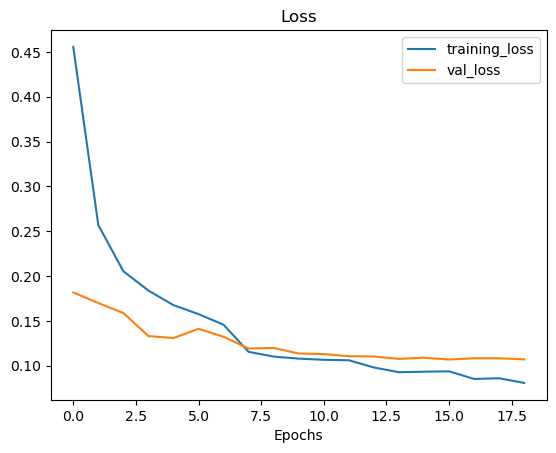

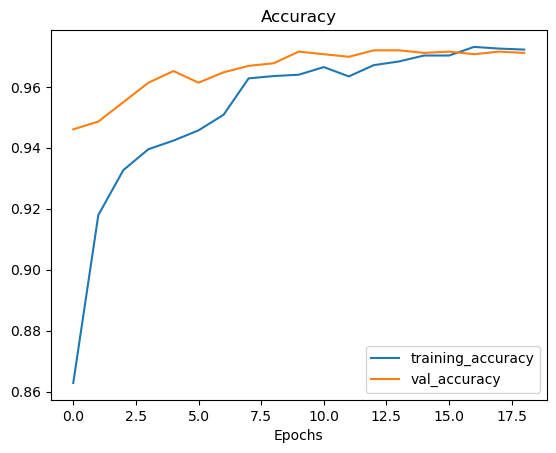

In [60]:
plot_loss_curves(EfficientNetV2S_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

# Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data

In [61]:
test_loss, test_accuracy = EfficientNetV2S_model.evaluate(test_data, verbose=0)

In [62]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.13483
Test Accuracy: 96.07%


Given the limited data set, we obtained a good accuracy of 97%.

Let's look at the main classification metrics

In [63]:
pred_probs = EfficientNetV2S_model.predict(test_data, verbose=1)

74/74 [==============================] - 30s 369ms/step


In [64]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [65]:
y_labels = []
for images, labels in test_data.unbatch(): 
    y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [66]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

     battery       0.97      0.95      0.96        95
  biological       0.98      0.99      0.98        99
   cardboard       0.94      0.97      0.95       234
     clothes       1.00      0.99      0.99       533
       glass       0.98      0.94      0.96       409
       metal       0.92      0.97      0.95       188
       paper       0.97      0.91      0.94       272
     plastic       0.93      0.95      0.94       253
       shoes       0.98      0.99      0.98       199
       trash       0.83      0.96      0.89        84

    accuracy                           0.96      2366
   macro avg       0.95      0.96      0.95      2366
weighted avg       0.96      0.96      0.96      2366



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions

In [67]:
import itertools

In [68]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

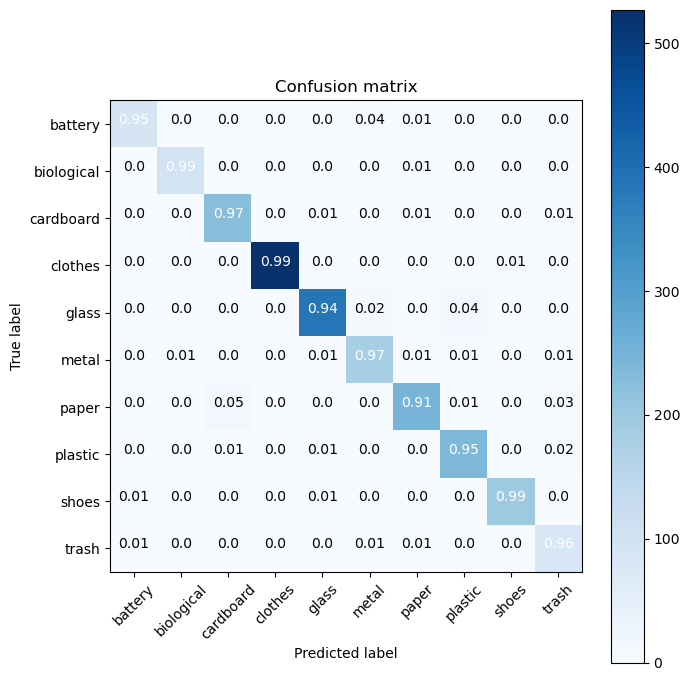

In [69]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

Visualizing several model predictions

In [70]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename
    
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        if i == 1:
            deploy_model_emission_tracker = EmissionsTracker()
            deploy_model_emission_tracker.start()
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            deploy_model_emissions: float = prepare_data_emission_tracker.stop()
            print(f"Deploy Model Carbon Emissions: {deploy_model_emissions} kg")
        else:
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class: 
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False);

[codecarbon INFO @ 03:05:38] [setup] RAM Tracking...
[codecarbon INFO @ 03:05:38] [setup] GPU Tracking...
[codecarbon INFO @ 03:05:38] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 03:05:38] [setup] CPU Tracking...
[codecarbon WARNING @ 03:05:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 03:05:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 03:05:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 03:05:40] >>> Tracker's metadata:
[codecarbon INFO @ 03:05:40]   Platform system: Linux-5.15.133+-x86_64-with-glibc2.35
[codecarbon INFO @ 03:05:40]   Python version: 3.10.10
[codecarbon INFO @ 03:05:40]   CodeCarbon version: 2.3.2
[codecarbon INFO @ 03:05:40]   Available RAM : 31.358 GB
[codecarbon INFO @ 03:05:40]   CPU count: 4
[codecarbon INFO @ 03:05:40]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 03:05:40]   GPU

Deploy Model Carbon Emissions: 0.037580766827328985 kg


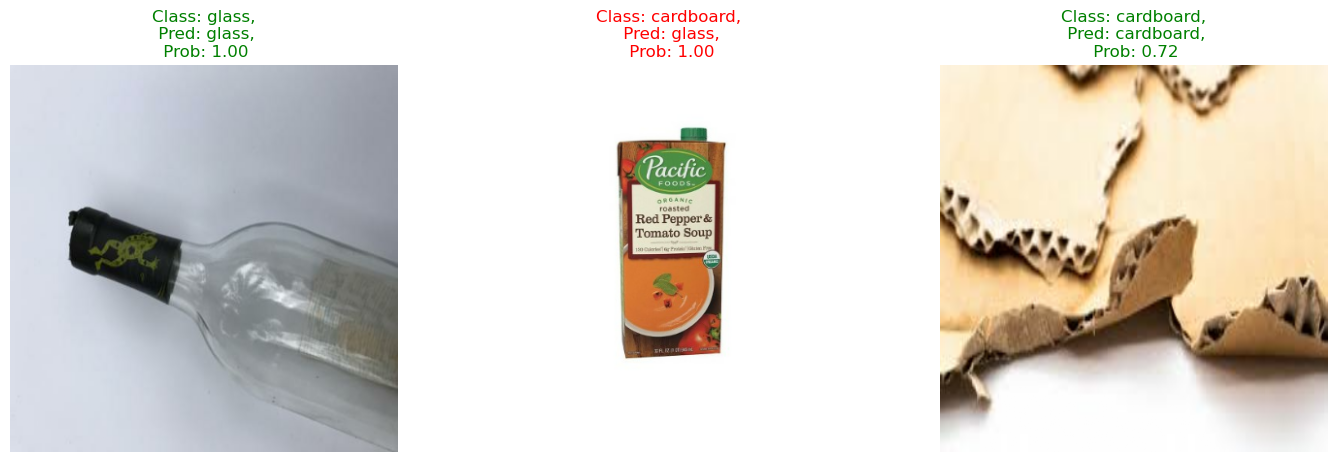

In [71]:
pred_random_images(EfficientNetV2S_model, test_path, class_names)

In [72]:
import pickle
pickle.dump(EfficientNetV2S_model,open("EfficientNetV2S_model.h5","wb"))
# EfficientNetV2S_model.save('EfficientNetV2S_model.h5')

In [73]:
ls ../working

EfficientNetV2S.h5        data/                      logs/
EfficientNetV2S_model.h5  emissions.csv              logs.zip
__notebook__.ipynb        garbage-classification.h5  runs/
